$(0,1)$ differences may occur for instances with $-70<x1<1, -20<x2<11$ from a global perspective. However, locally they may occur for instances with:
- $-60<x1<-49, 0<x2<11$
- $-20<x1<1, -20<x2<11$
    
Details:
- Differences: $-55 ≤ x1 ≤ 0, -15 ≤ x2 ≤ 10$ (20 instances)
- R: $x1 ≤ 0$
    - CF: $x1≥1 \rightarrow (1,1), (1,0)$
    - RL: $x1≥-55, -15 ≤ x2 ≤ 10$
        - CF: $x1≤-60 \rightarrow (0,0)$
        - CF: $x2≤-20 \rightarrow (0,0)$
        - CF: $x2≥11 \rightarrow (0,0)$
        - RLL: $x1≤-10, x2≥-5$ (8 instances different)
            - CF: $x2≤-10 \rightarrow (0,0)$
            - RLLL: $x1≥-15, x2≤0$ (4 instances different)
                - CF: $x1≤-20$
                - CF: $x2≥1 \rightarrow (0,0)$
            - RLLR: $x1 ≤ -50, x2 ≥ 5$ (4 instances different)
                - CF: $x1≥-49 \rightarrow (0,0)$
                - CF: $x2≤0 \rightarrow (0,0)$
        - RLR: $x1≥-5$ (12 instances different)
            - CF: $x1≤-20 \rightarrow (0,0)$
            - RLRL: $x2 ≤ -10$ (4 instances different)
                - CF: $x1≤-10 \rightarrow (0,0)$
            - RLRR: $x2≥-5$ (8 instances different)
                - RLRRL: $x2≤0$ (4 instances different)
                - RLRRR: $x2≥5$ (4 instances different)
                    - CF: $x1≤-10 \rightarrow (0,0)$

$(1,0)$ differences may occur locally for instances with $0<x1<11, 0<x2<11$

Details:
- Differences: $5≤x1≤10, 5≤x2≤10$ (4 instances)
- R: $x1≥5$
    - CF: $x1≤0 \rightarrow (0,1)$
    - RL: $x1≤10, 5≤x2≤10$
        - CF: $x1≥11 \rightarrow (1,1)$
        - CF: $x2≤0 \rightarrow (1,1)$
        - CF: $x2≥11 \rightarrow (1,1)$

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances
from clustering import make_clustering, plot_dendrogram
from tasks.cluster_example import make_task

In [2]:
with open('shap.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = \
        pickle.load(f)

In [3]:
clf_a, clf_b, X, y, feature_names = make_task()

In [4]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

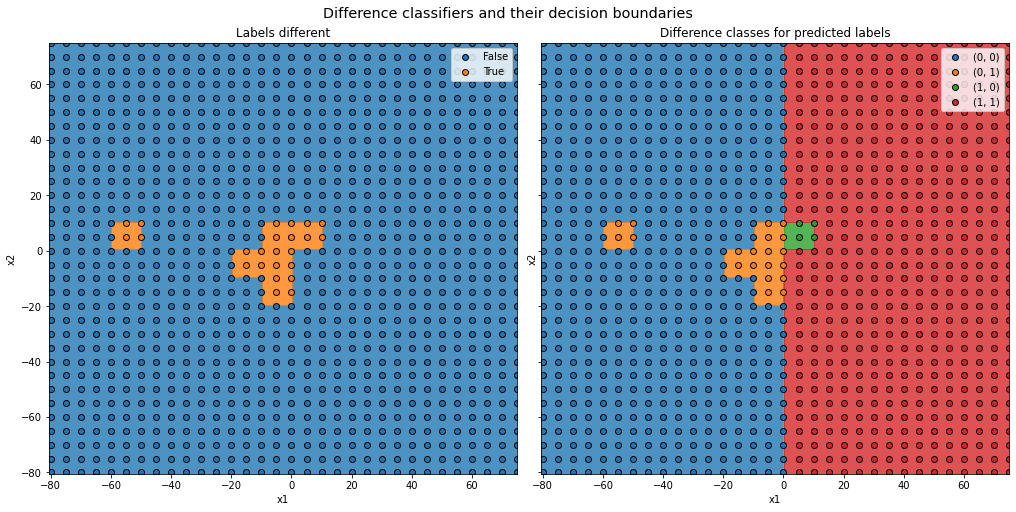

In [5]:
comparer.plot_decision_boundaries(X)

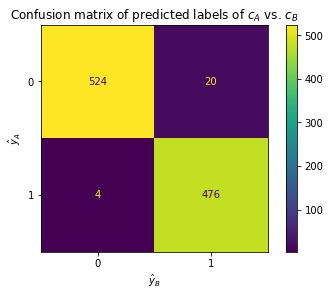

In [6]:
comparer.plot_confusion_matrix(X)

In [7]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

CPU times: user 8.93 s, sys: 112 ms, total: 9.05 s
Wall time: 9.17 s


In [8]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((1024, 2), (0,), (0,))

In [6]:
xlim = explanations.data[:, 0].min() - 0.5, explanations.data[:, 0].max() + 0.5
ylim = explanations.data[:, 1].min() - 0.5, explanations.data[:, 1].max() + 0.5

# Traditional SHAP Explanations

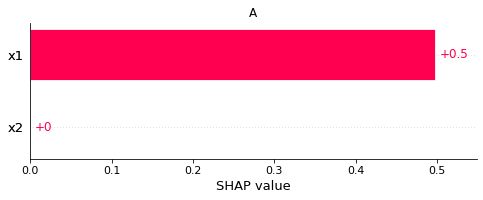

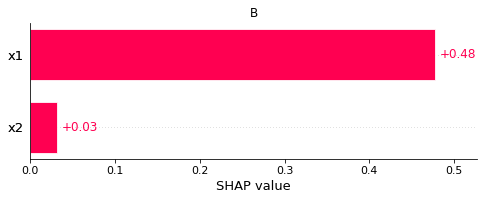

In [9]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [10]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [11]:
node, Z = make_clustering(comparer, explanations.indiv.labels[:, :, 1])

root
(0, 0)    524
(1, 1)    476
(0, 1)     20
(1, 0)      4
dtype: int64


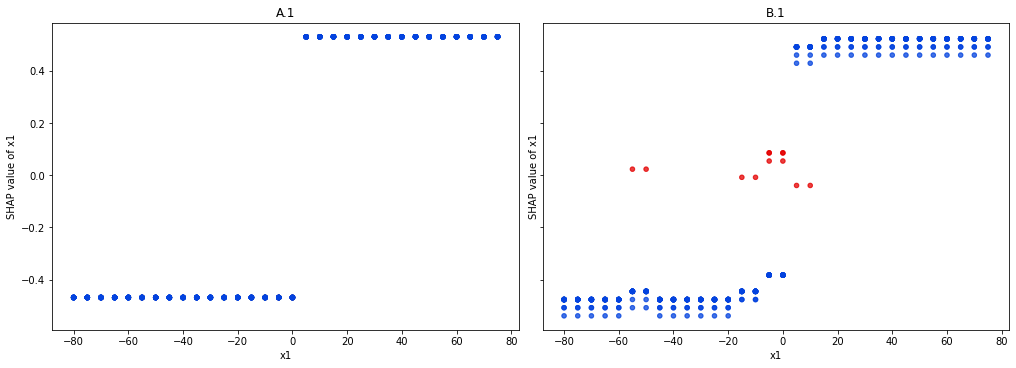

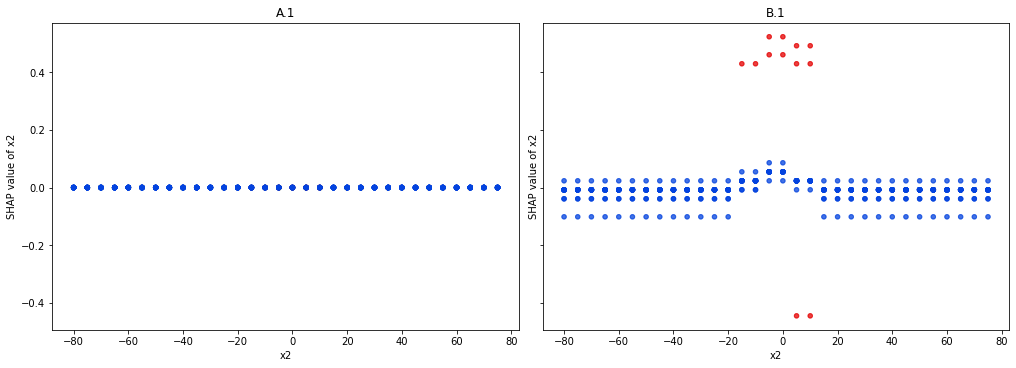

In [12]:
for feature in feature_order:
    node.plot_feature(feature, alpha=0.5)

# Difference Classifier SHAP Explanations

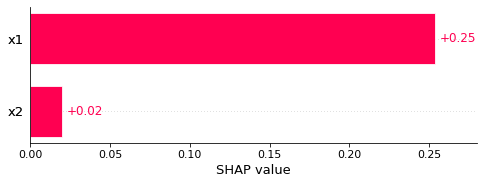

In [7]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(feature_importances)

In [8]:
global_feature_order = feature_order

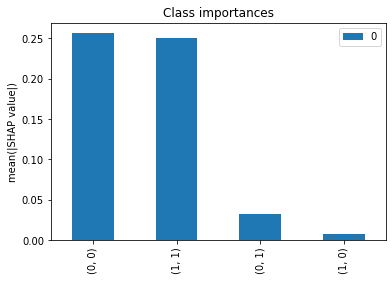

In [9]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

## Clustering of Class $(0,1)$ SHAP Values

In [10]:
node, Z = make_clustering(comparer, explanations.mclass_diff.labels, '(0, 1)', ['(0, 0)', '(0, 1)', '(1, 1)'])

root
(0, 0)    524
(1, 1)    476
(0, 1)     20
(1, 0)      4
dtype: int64


### Root Node

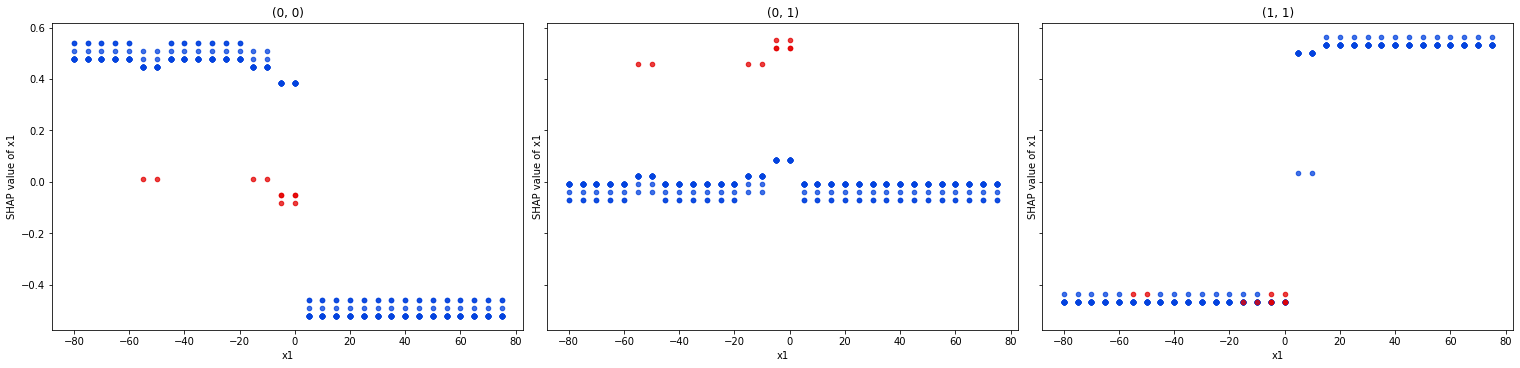

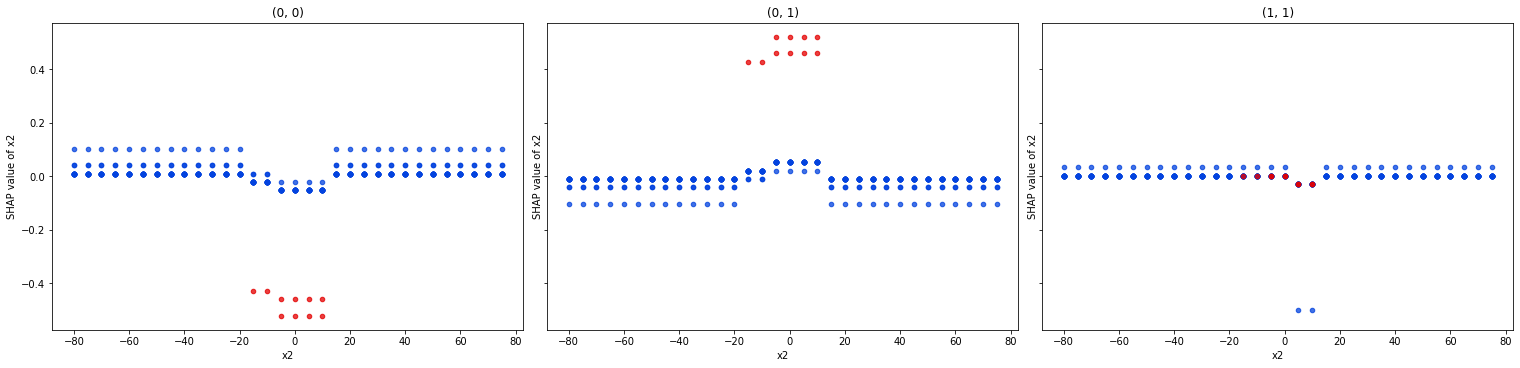

In [11]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [12]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,1024.000000,20.000000
mean,-2.500000,-2.500000,-14.500000
std,46.188022,46.188022,20.059123
min,-80.000000,-80.000000,-55.000000
25%,-41.250000,-41.250000,-15.000000
50%,-2.500000,-2.500000,-5.000000
75%,36.250000,36.250000,0.000000
max,75.000000,75.000000,0.000000


In [13]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,1024.000000,20.000000
mean,-2.500000,-2.500000,-0.500000
std,46.188022,46.188022,8.094833
min,-80.000000,-80.000000,-15.000000
25%,-41.250000,-41.250000,-5.000000
50%,-2.500000,-2.500000,0.000000
75%,36.250000,36.250000,5.000000
max,75.000000,75.000000,10.000000


### Node R

In [14]:
node = node.get_right()

R
(0, 0)    524
(0, 1)     20
dtype: int64


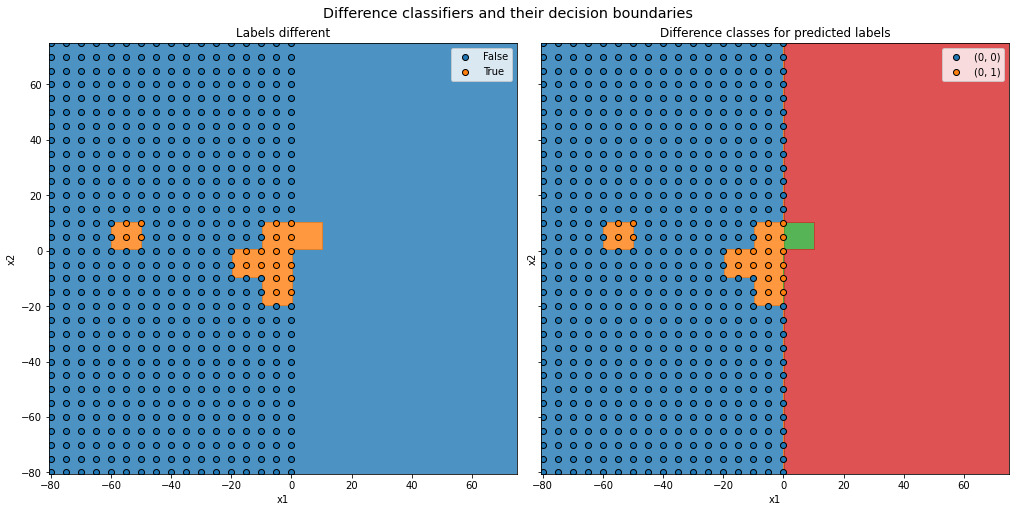

In [15]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

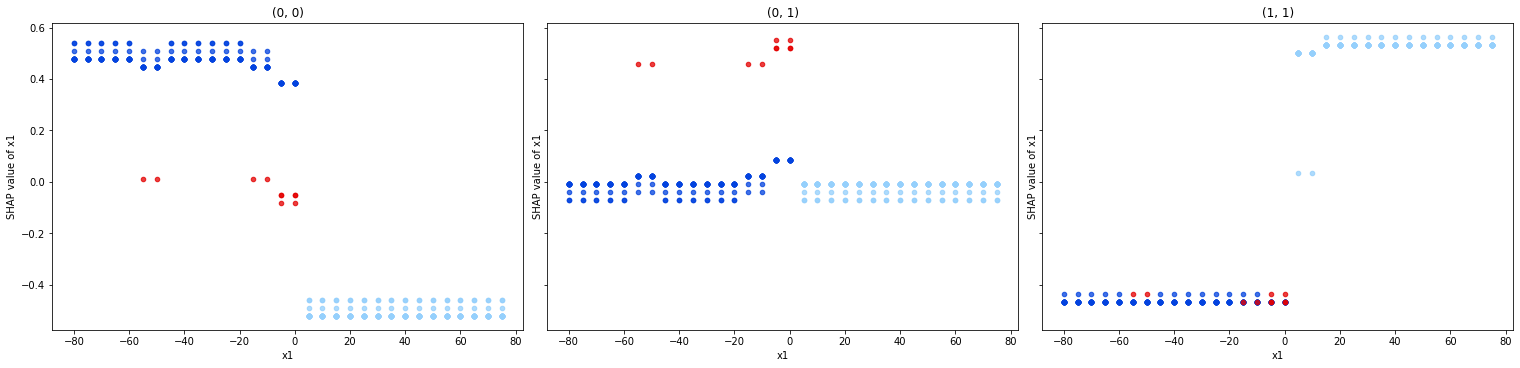

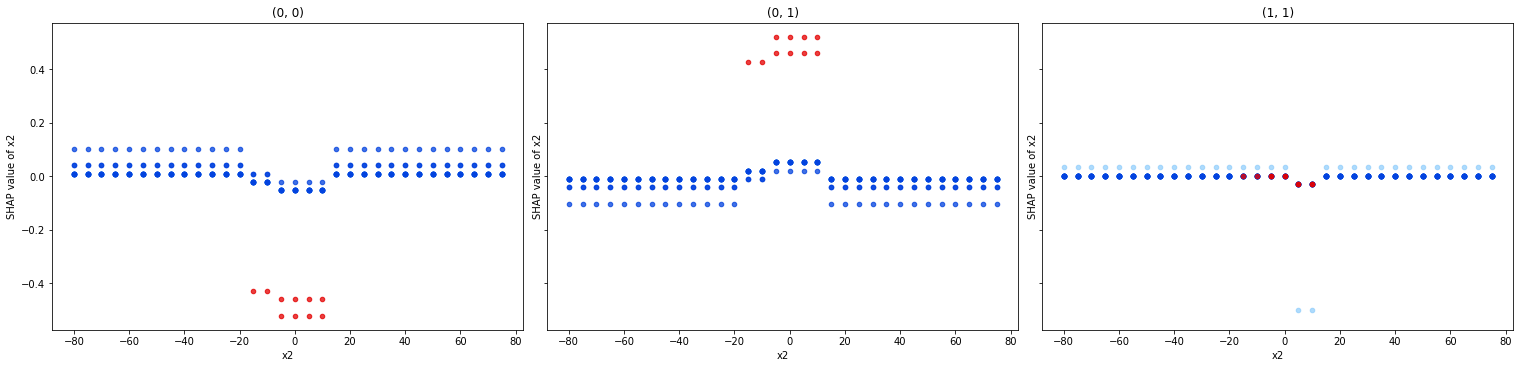

In [16]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [17]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,544.000000,20.000000
mean,-2.500000,-40.000000,-14.500000
std,46.188022,24.517442,20.059123
min,-80.000000,-80.000000,-55.000000
25%,-41.250000,-60.000000,-15.000000
50%,-2.500000,-40.000000,-5.000000
75%,36.250000,-20.000000,0.000000
max,75.000000,0.000000,0.000000


In [18]:
node.test(x1=0)
node.test(x1=1)

,before,after
"(0, 1)",20,20


,before,after
"(0, 1)",20.0,NaN
"(1, 0)",NaN,8.0
"(1, 1)",NaN,12.0


### Node RL

In [19]:
node = node.get_left()

RL
(0, 1)    20
dtype: int64


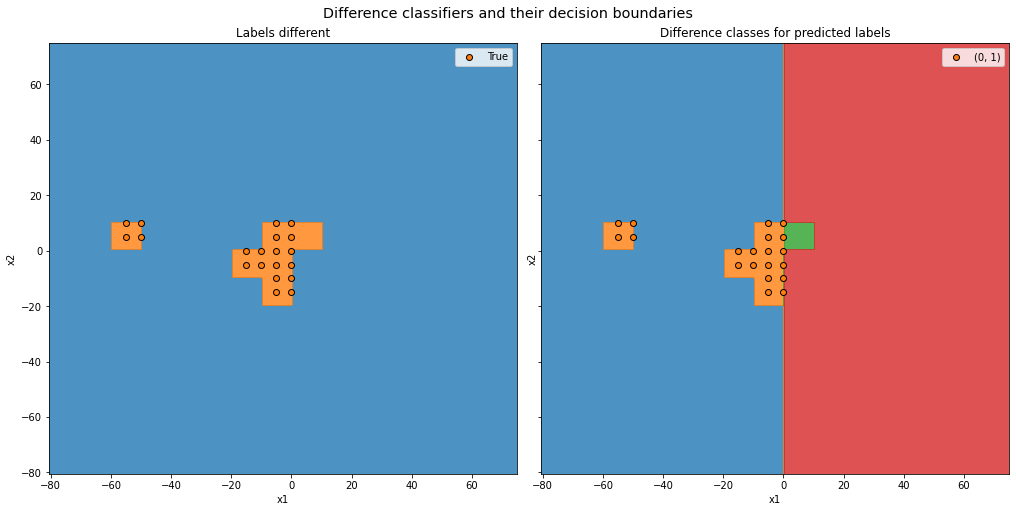

In [20]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

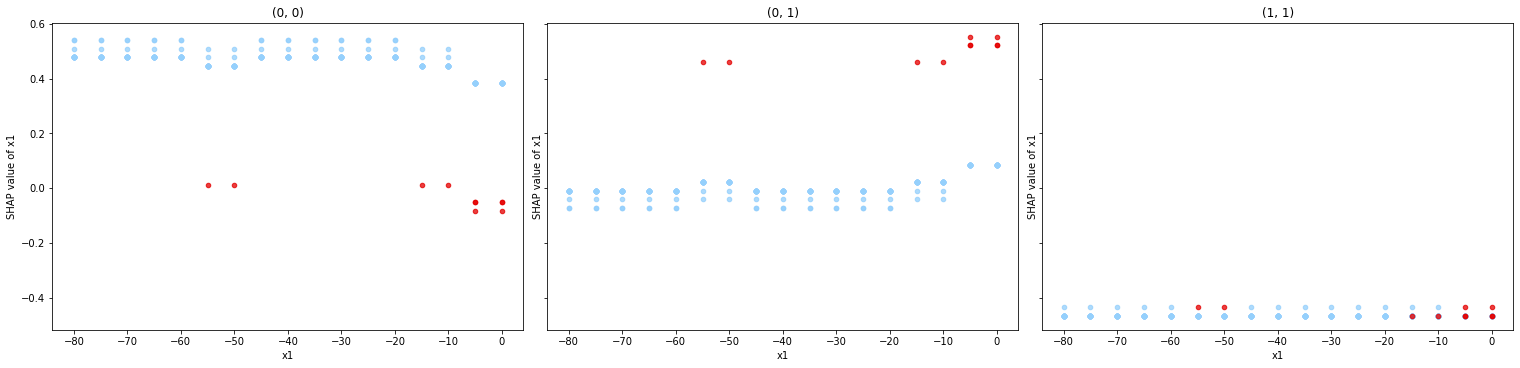

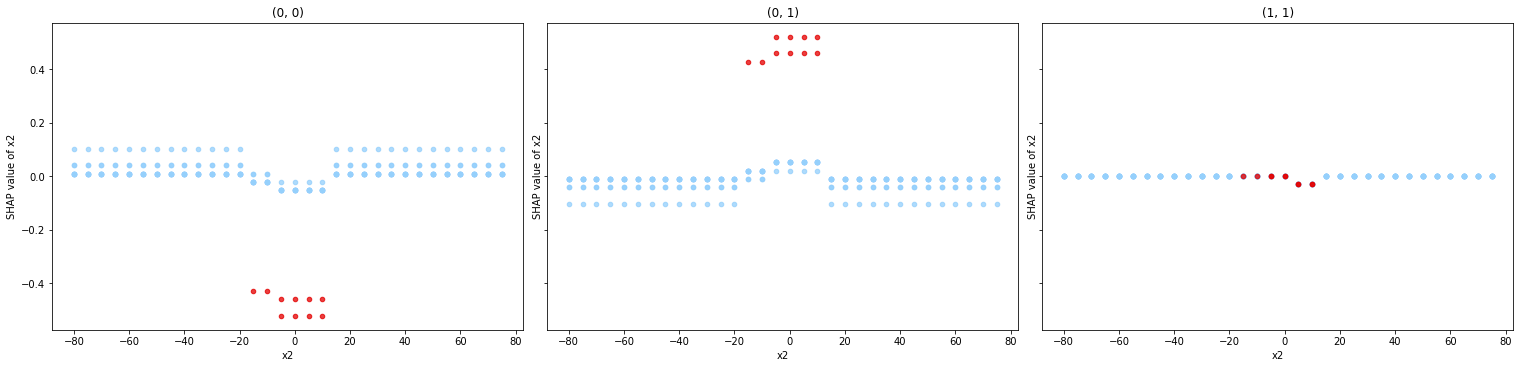

In [21]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [22]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,20.000000,20.000000
mean,-2.500000,-14.500000,-14.500000
std,46.188022,20.059123,20.059123
min,-80.000000,-55.000000,-55.000000
25%,-41.250000,-15.000000,-15.000000
50%,-2.500000,-5.000000,-5.000000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


In [23]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,20.000000,20.000000
mean,-2.500000,-0.500000,-0.500000
std,46.188022,8.094833,8.094833
min,-80.000000,-15.000000,-15.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,0.000000,0.000000
75%,36.250000,5.000000,5.000000
max,75.000000,10.000000,10.000000


In [24]:
node.test(x1=-60)

,before,after
"(0, 0)",NaN,20.0
"(0, 1)",20.0,NaN


In [25]:
node.test(x2=-20)

,before,after
"(0, 0)",NaN,20.0
"(0, 1)",20.0,NaN


In [26]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,20.0
"(0, 1)",20.0,NaN


### Node RLL

In [27]:
node = node.get_left()

RLL
(0, 1)    8
dtype: int64


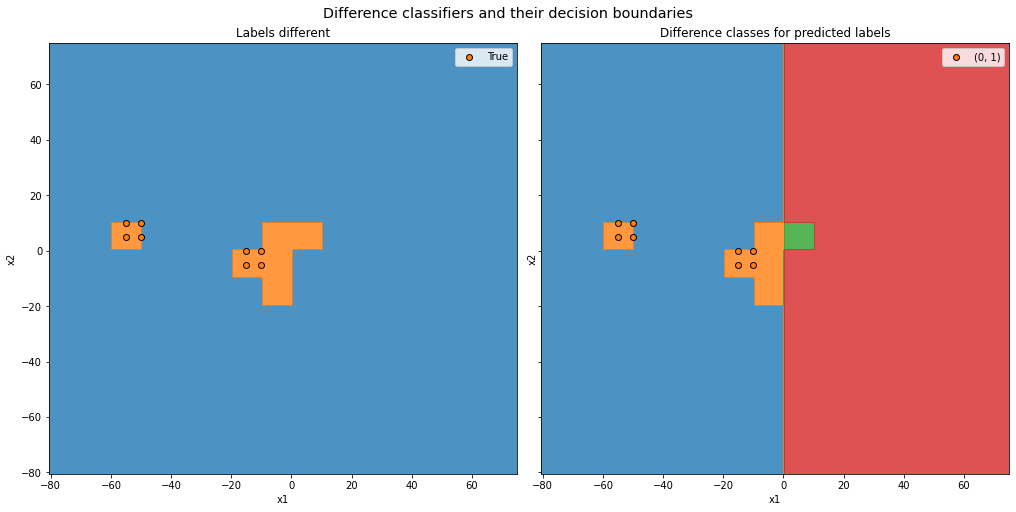

In [28]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

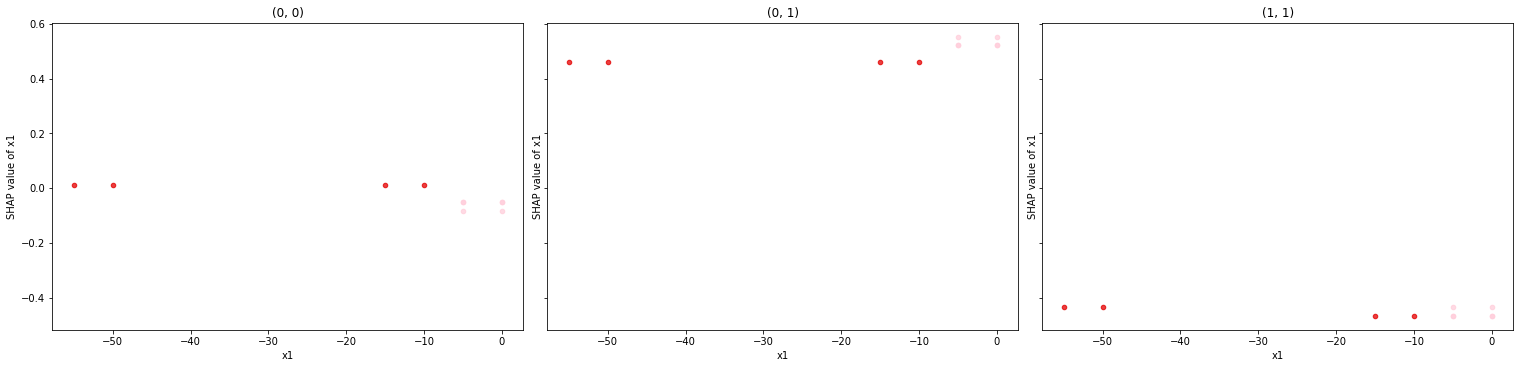

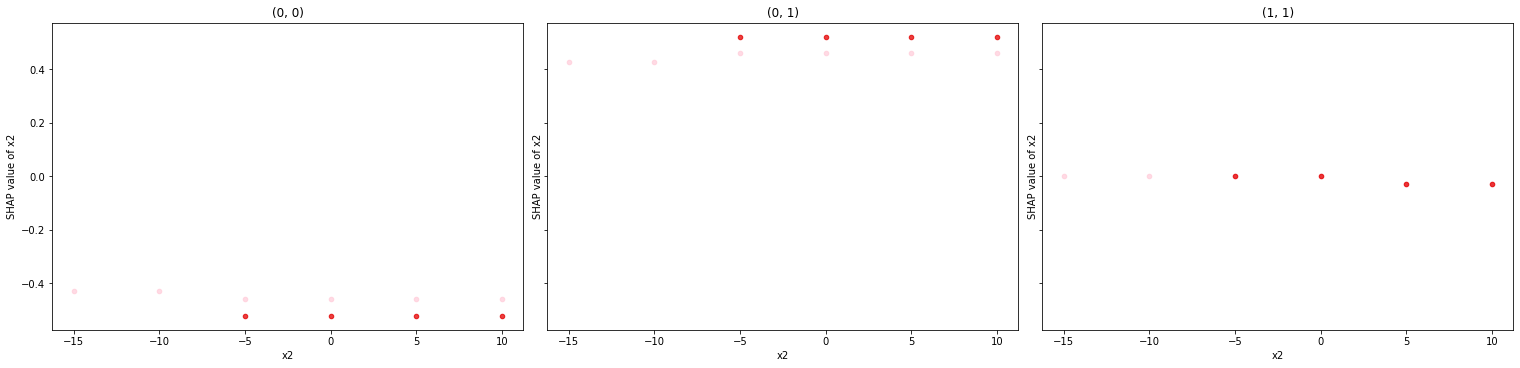

In [29]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [30]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,8.00000,8.00000
mean,-2.500000,-32.50000,-32.50000
std,46.188022,21.54729,21.54729
min,-80.000000,-55.00000,-55.00000
25%,-41.250000,-51.25000,-51.25000
50%,-2.500000,-32.50000,-32.50000
75%,36.250000,-13.75000,-13.75000
max,75.000000,-10.00000,-10.00000


In [31]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,8.000000,8.000000
mean,-2.500000,2.500000,2.500000
std,46.188022,5.976143,5.976143
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-1.250000,-1.250000
50%,-2.500000,2.500000,2.500000
75%,36.250000,6.250000,6.250000
max,75.000000,10.000000,10.000000


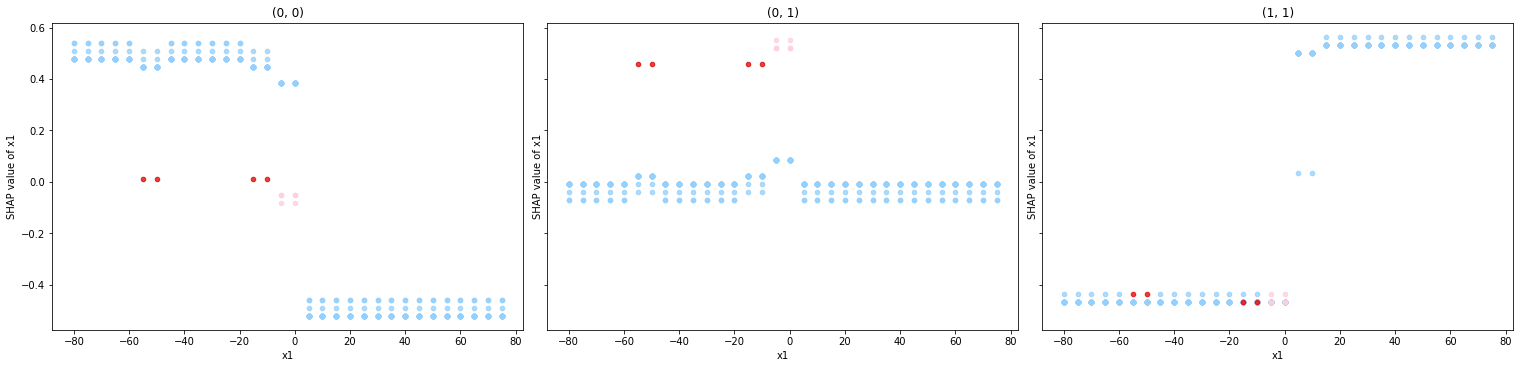

In [32]:
node.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [33]:
node.test(x1=-60)

,before,after
"(0, 0)",NaN,8.0
"(0, 1)",8.0,NaN


In [34]:
node.test(x1=1)

,before,after
"(0, 1)",8.0,NaN
"(1, 0)",NaN,4.0
"(1, 1)",NaN,4.0


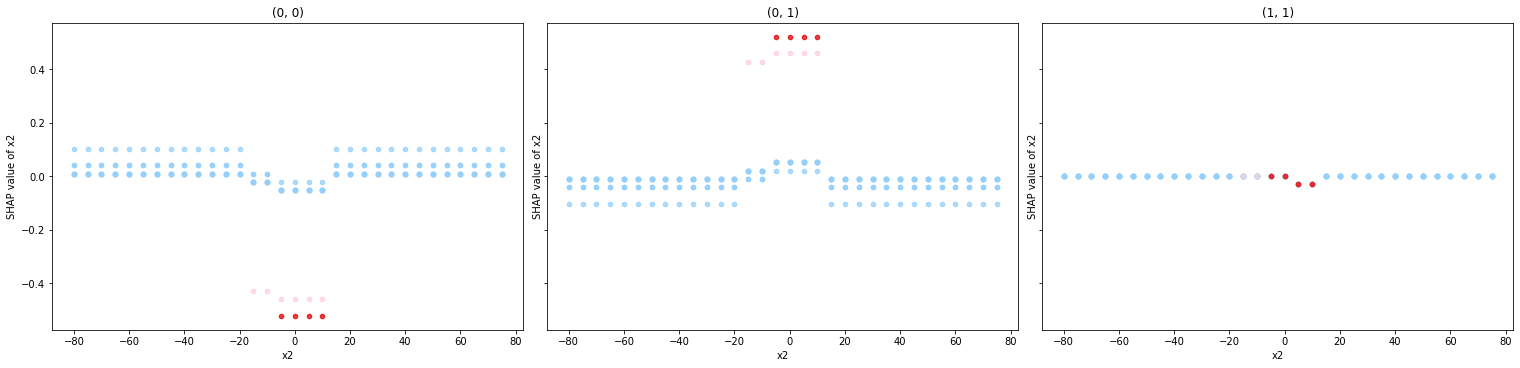

In [35]:
node.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [36]:
node.test(x2=-10)

,before,after
"(0, 0)",NaN,8.0
"(0, 1)",8.0,NaN


In [37]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,8.0
"(0, 1)",8.0,NaN


### Node RLLL

In [38]:
node = node.get_left()

RLLL
(0, 1)    4
dtype: int64


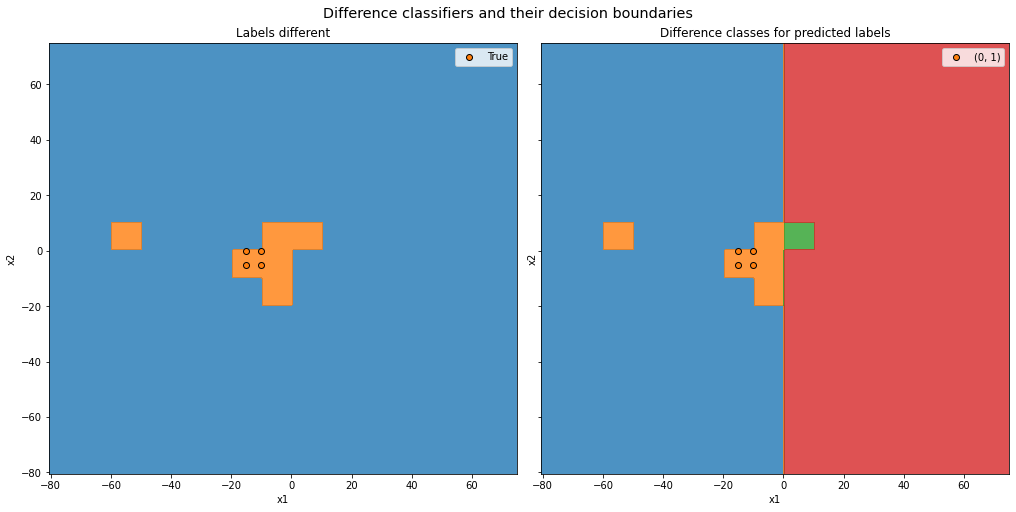

In [39]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

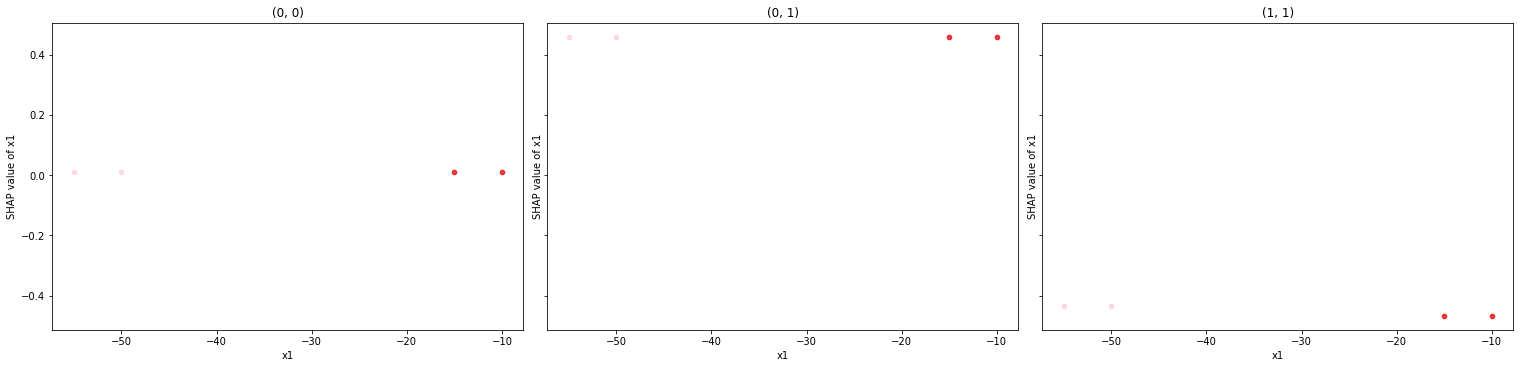

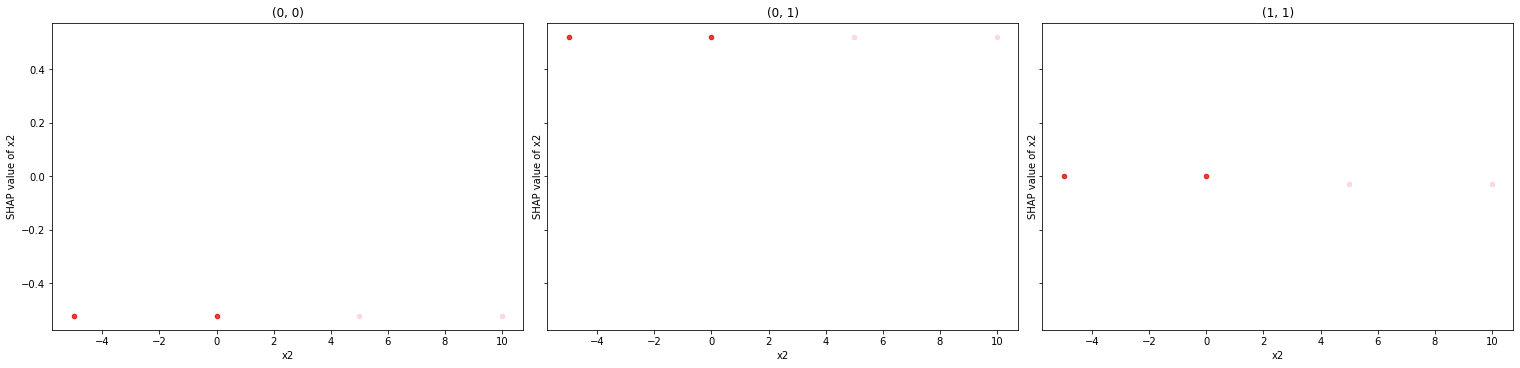

In [40]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [41]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-12.500000,-12.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-15.000000,-15.000000
25%,-41.250000,-15.000000,-15.000000
50%,-2.500000,-12.500000,-12.500000
75%,36.250000,-10.000000,-10.000000
max,75.000000,-10.000000,-10.000000


In [42]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


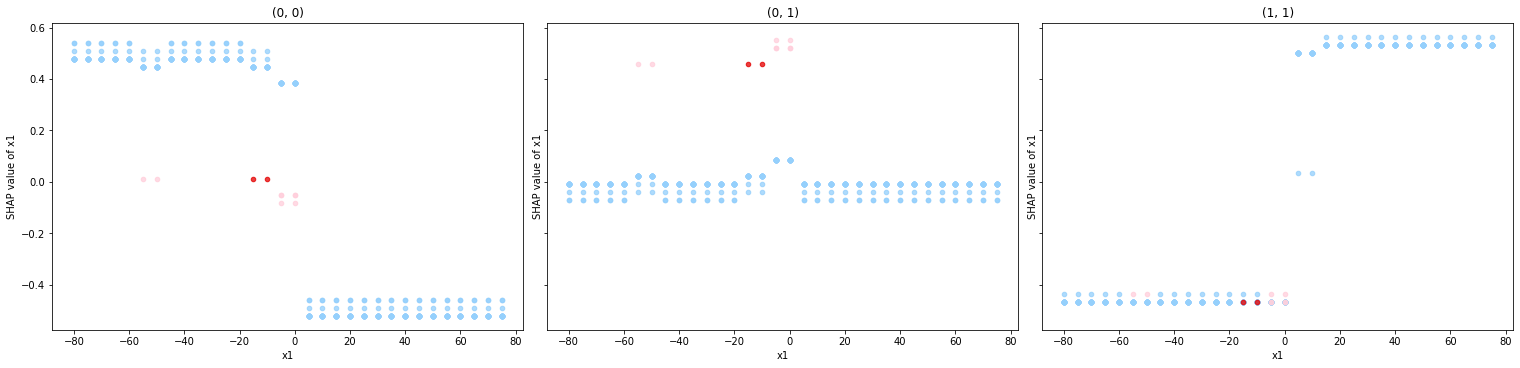

In [43]:
node.parent.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [44]:
node.test(x1=-20)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [45]:
node.test(x1=1)

,before,after
"(0, 1)",4.0,NaN
"(1, 1)",NaN,4.0


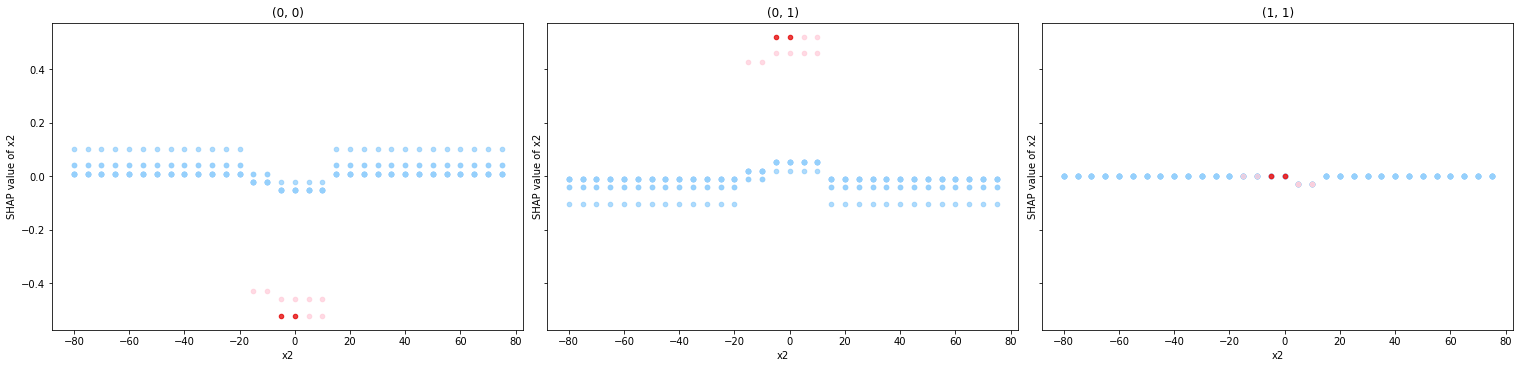

In [46]:
node.parent.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [47]:
node.test(x2=-10)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [48]:
node.test(x2=1)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [49]:
node.get_left()

RLLLL
(0, 1)    1
dtype: int64


ClusterNode(526)

### Node RLLR

In [50]:
node = node.parent.get_right()

RLLR
(0, 1)    4
dtype: int64


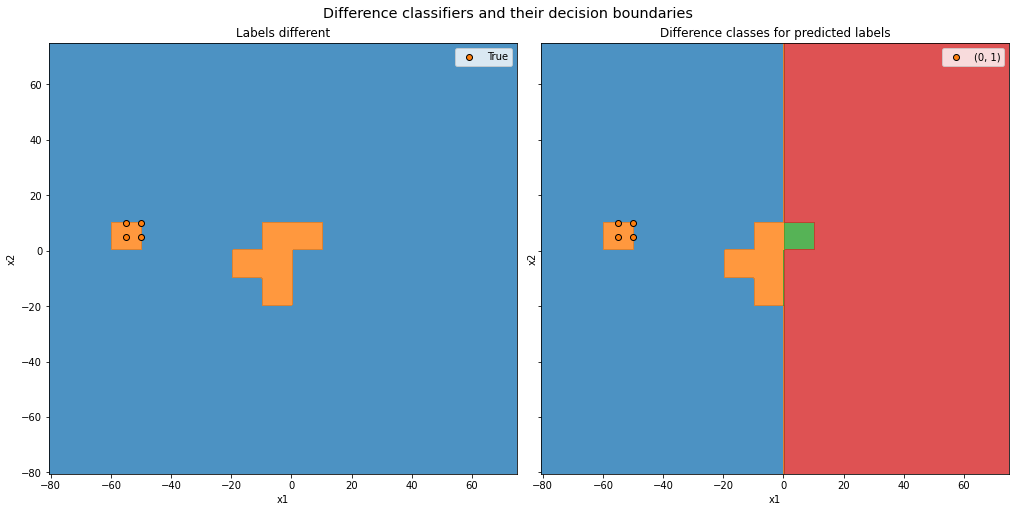

In [51]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

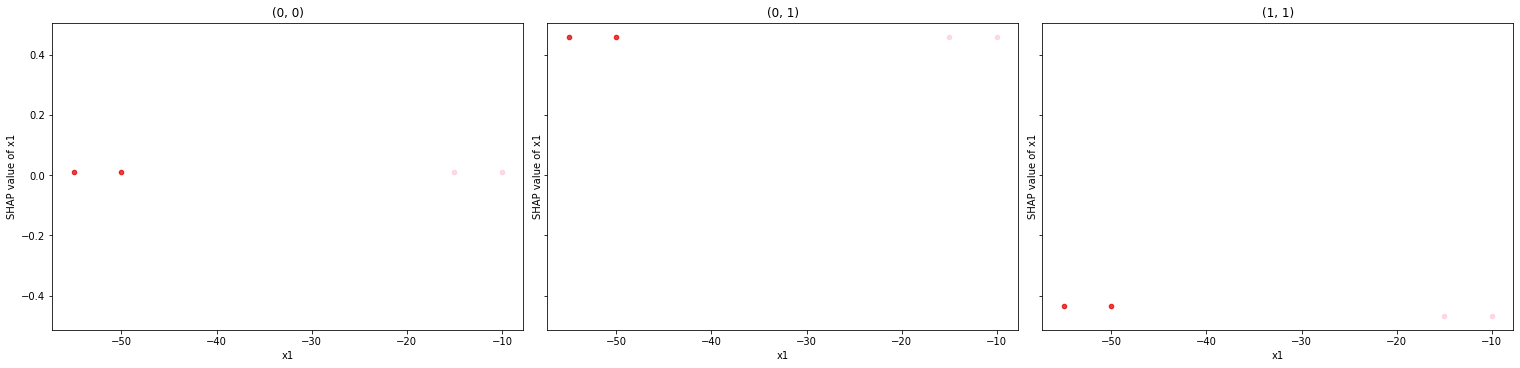

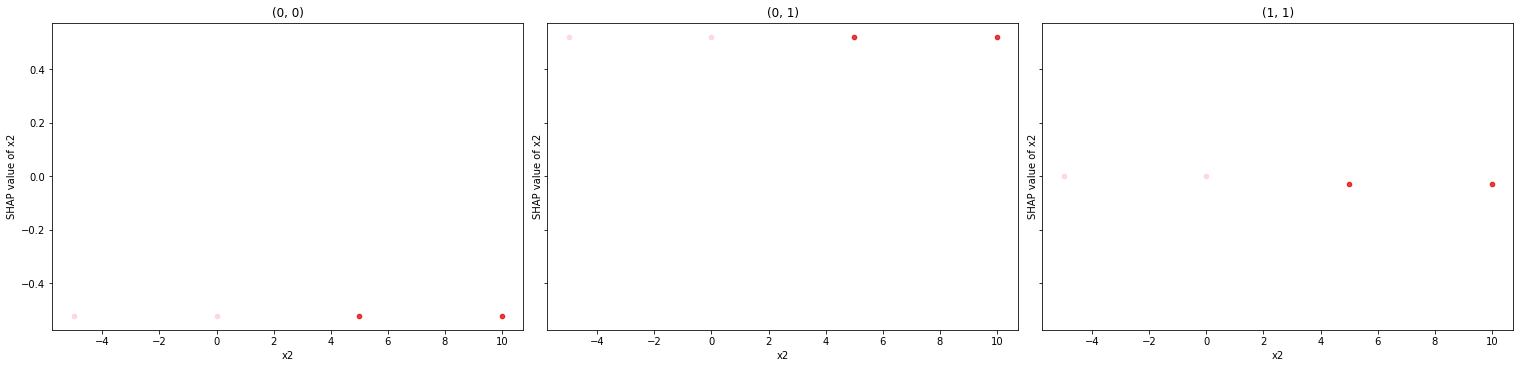

In [52]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [53]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-52.500000,-52.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-55.000000,-55.000000
25%,-41.250000,-55.000000,-55.000000
50%,-2.500000,-52.500000,-52.500000
75%,36.250000,-50.000000,-50.000000
max,75.000000,-50.000000,-50.000000


In [54]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,7.500000,7.500000
std,46.188022,2.886751,2.886751
min,-80.000000,5.000000,5.000000
25%,-41.250000,5.000000,5.000000
50%,-2.500000,7.500000,7.500000
75%,36.250000,10.000000,10.000000
max,75.000000,10.000000,10.000000


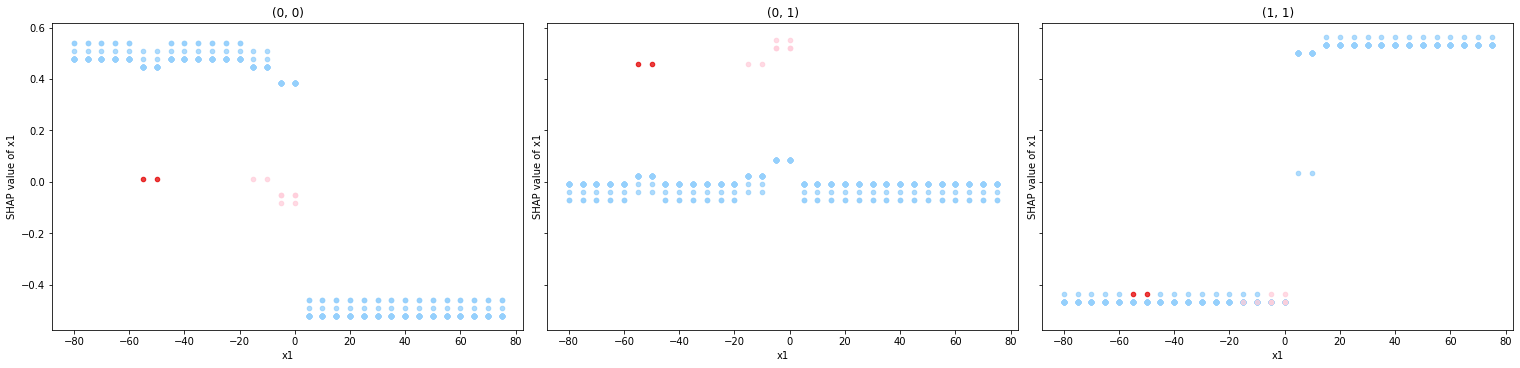

In [55]:
node.parent.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [56]:
node.test(x1=-60)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [57]:
node.test(x1=-49)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


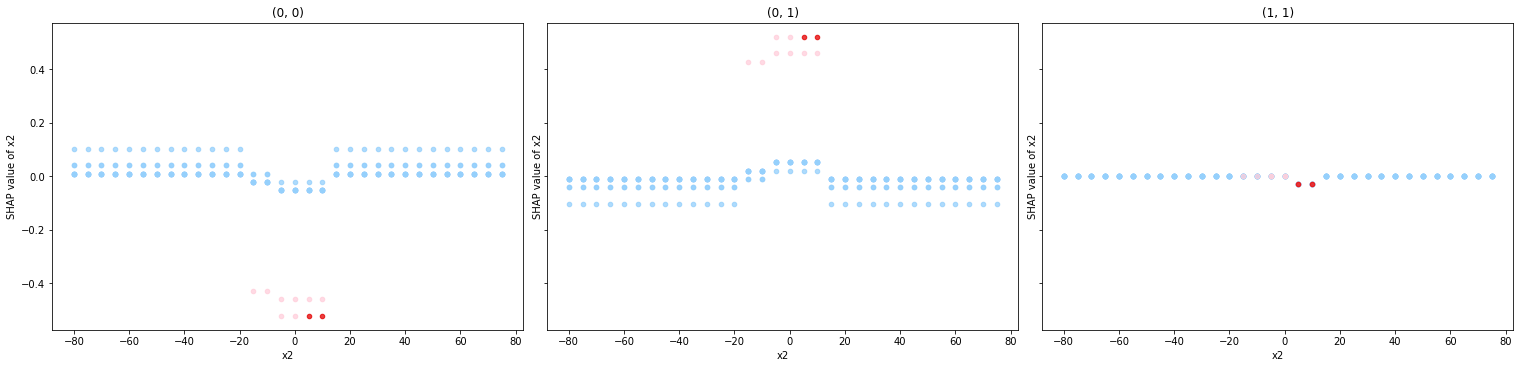

In [58]:
node.parent.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [59]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [60]:
node.test(x2=0)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


### Node RLR

In [61]:
node = node.parent.parent.get_right()

RLR
(0, 1)    12
dtype: int64


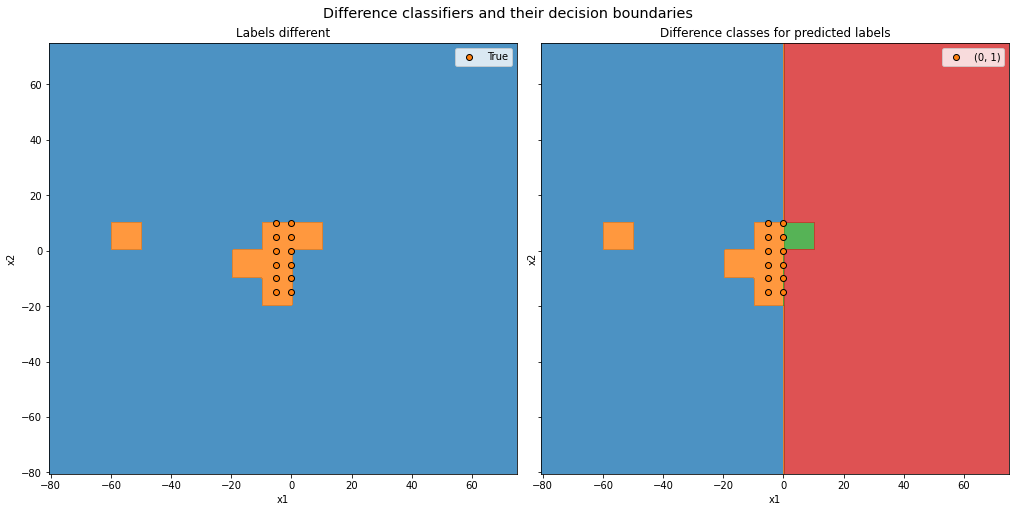

In [62]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

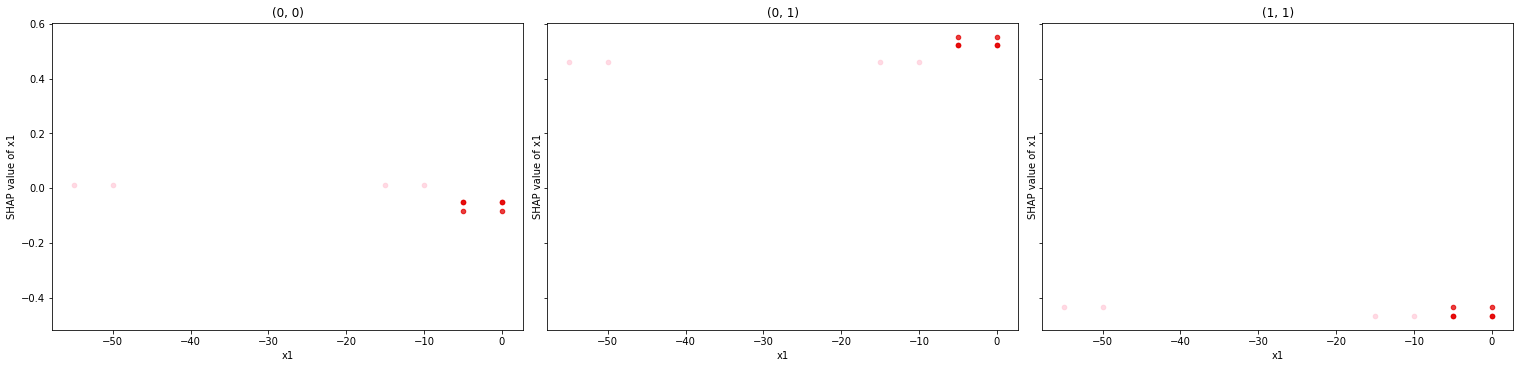

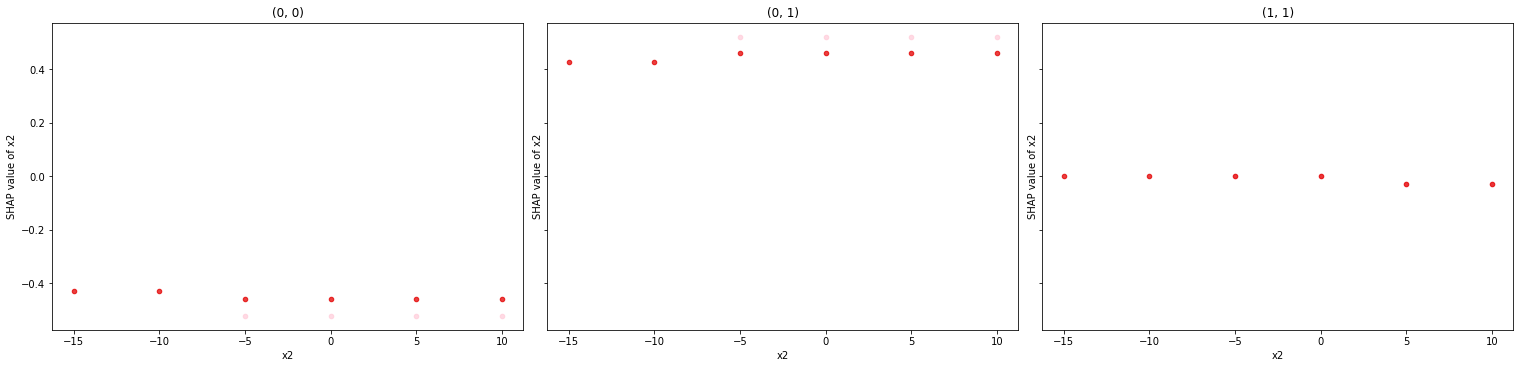

In [63]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [64]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,12.000000,12.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.611165,2.611165
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


In [65]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,12.000000,12.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,8.918826,8.918826
min,-80.000000,-15.000000,-15.000000
25%,-41.250000,-10.000000,-10.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,5.000000,5.000000
max,75.000000,10.000000,10.000000


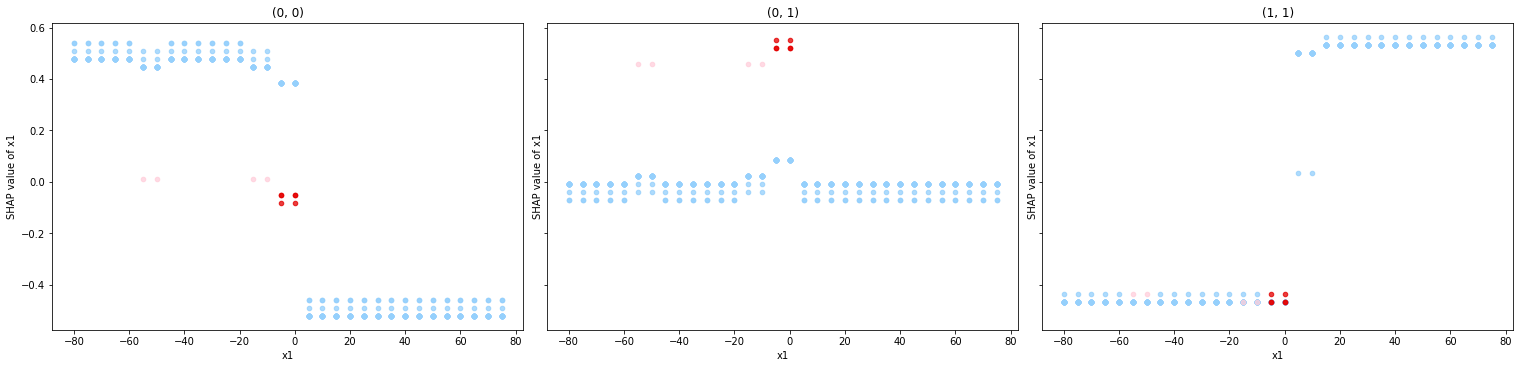

In [66]:
node.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [67]:
node.test(x1=-20)

,before,after
"(0, 0)",NaN,12.0
"(0, 1)",12.0,NaN


In [68]:
node.test(x1=1)

,before,after
"(0, 1)",12.0,NaN
"(1, 0)",NaN,4.0
"(1, 1)",NaN,8.0


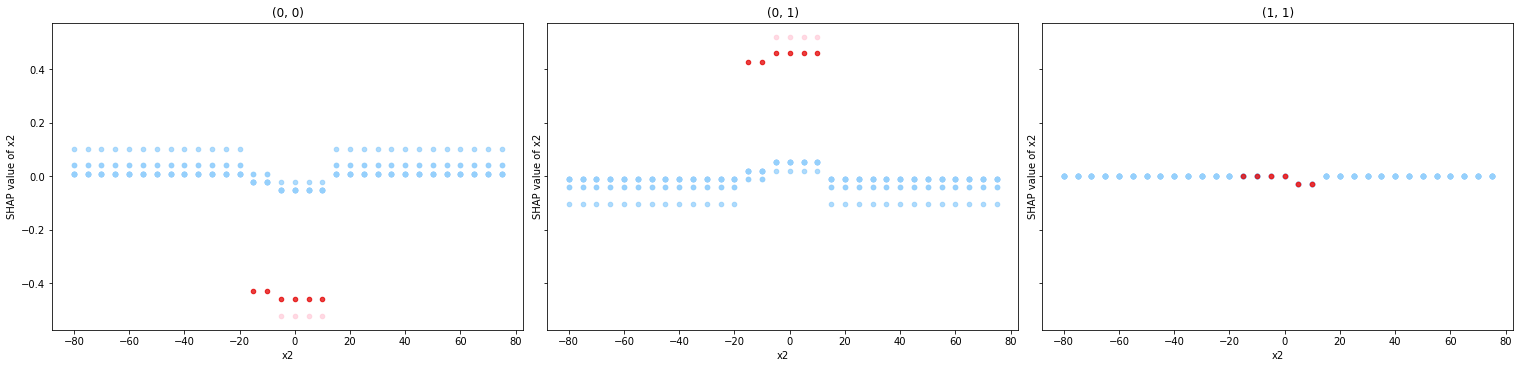

In [69]:
node.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [70]:
node.test(x2=-20)

,before,after
"(0, 0)",NaN,12.0
"(0, 1)",12.0,NaN


In [71]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,12.0
"(0, 1)",12.0,NaN


### Node RLRL

In [72]:
node = node.get_left()

RLRL
(0, 1)    4
dtype: int64


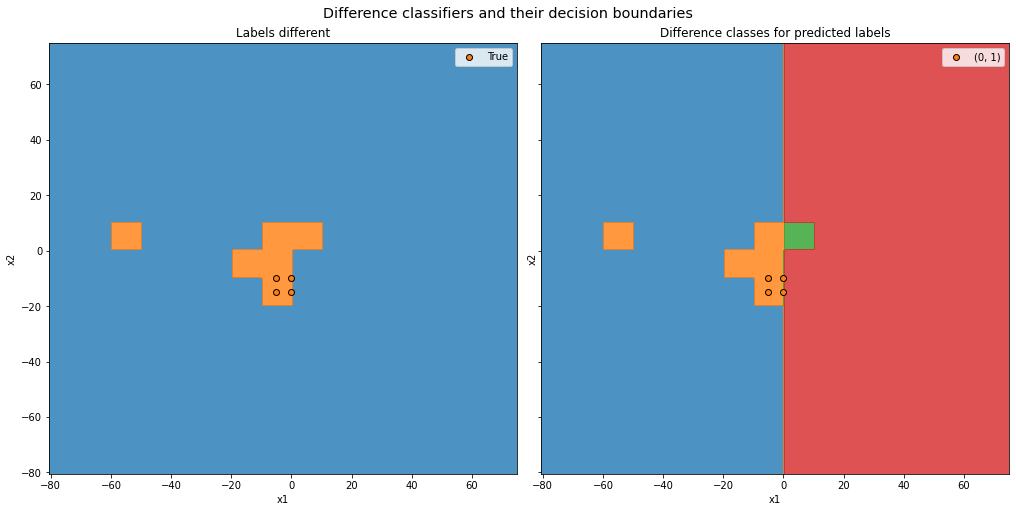

In [73]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

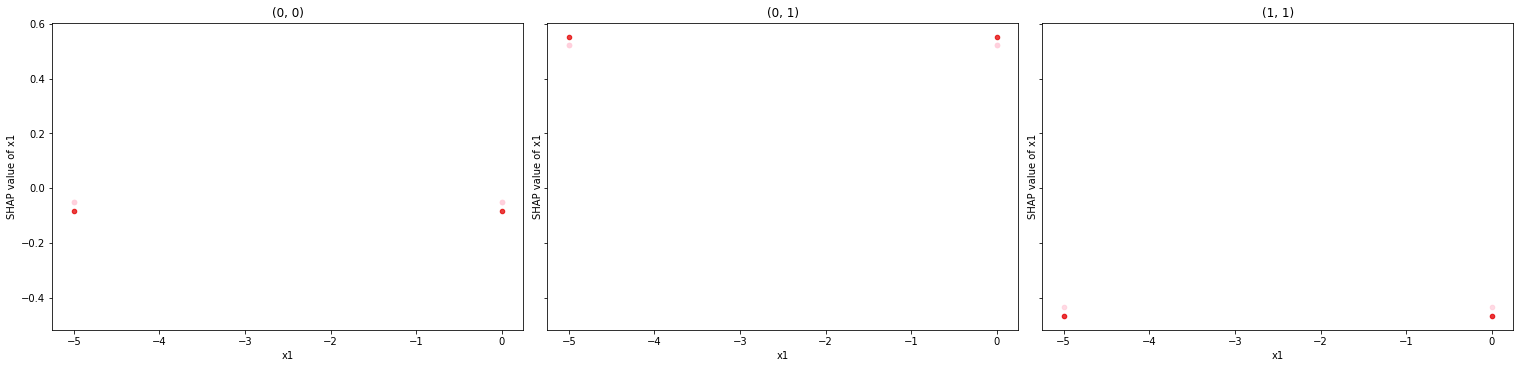

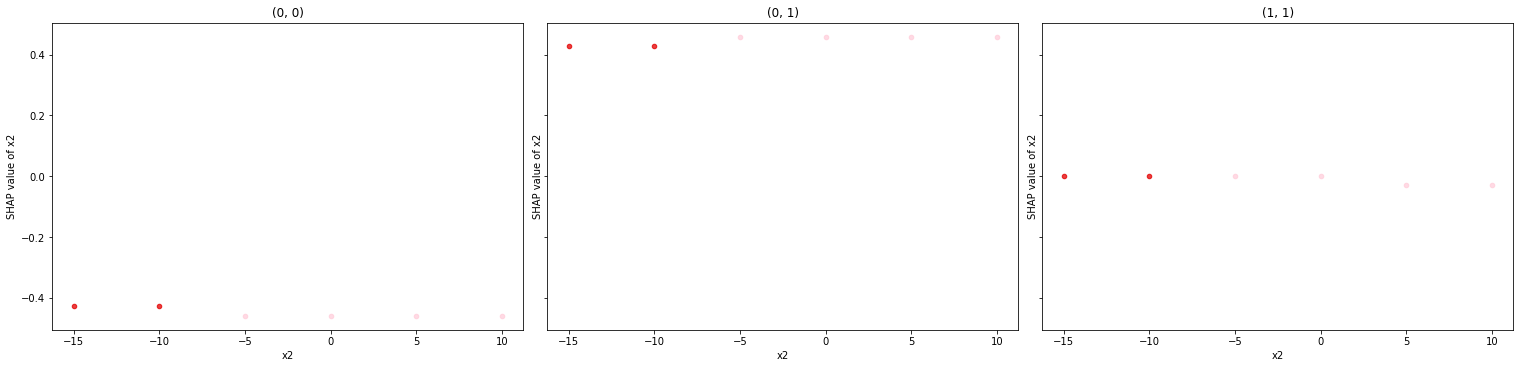

In [74]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [75]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


In [76]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-12.500000,-12.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-15.000000,-15.000000
25%,-41.250000,-15.000000,-15.000000
50%,-2.500000,-12.500000,-12.500000
75%,36.250000,-10.000000,-10.000000
max,75.000000,-10.000000,-10.000000


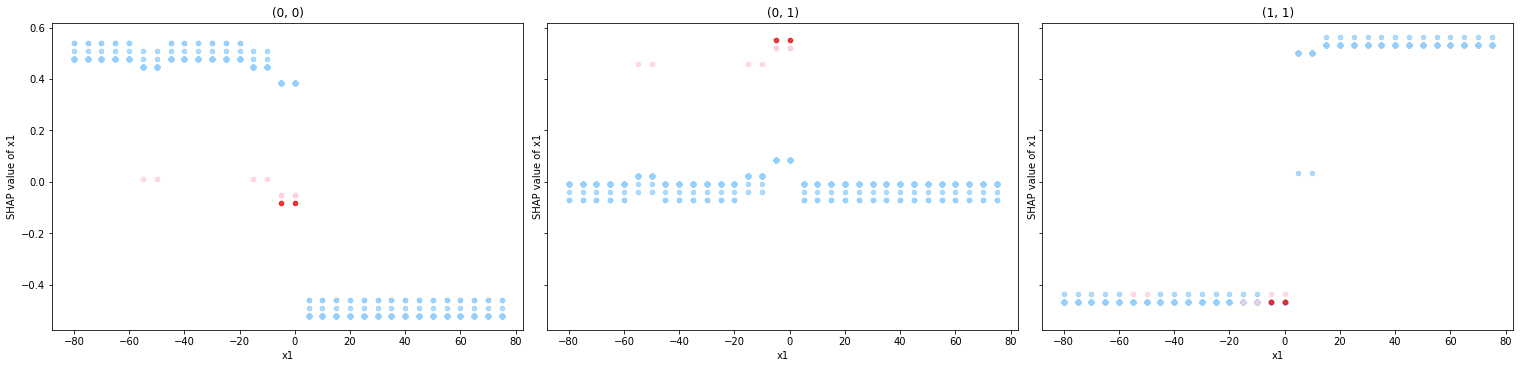

In [77]:
node.parent.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [78]:
node.test(x1=-10)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [79]:
node.test(x1=1)

,before,after
"(0, 1)",4.0,NaN
"(1, 1)",NaN,4.0


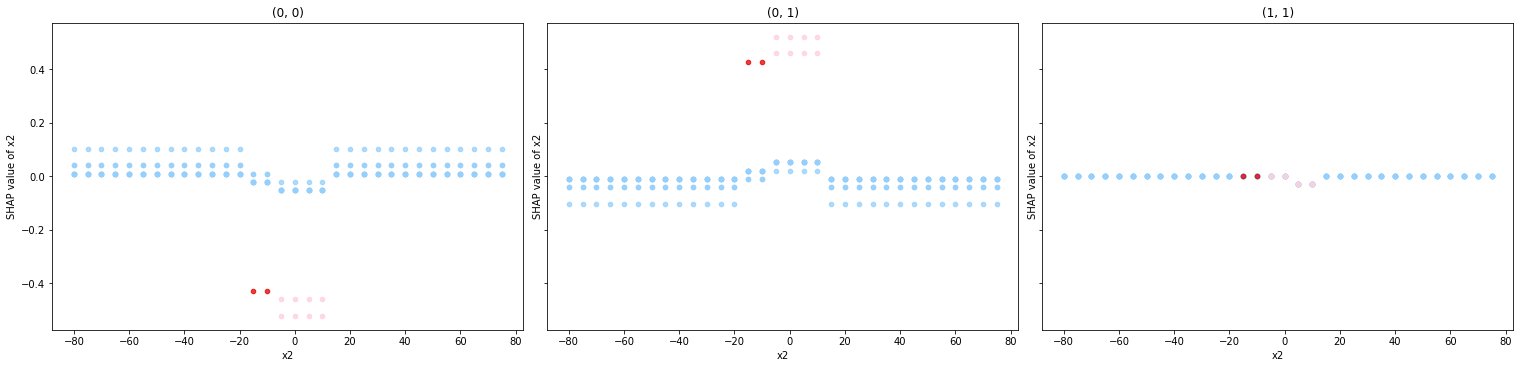

In [80]:
node.parent.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [81]:
node.test(x2=-20)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [82]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


### Node RLRR

In [83]:
node = node.parent.get_right()

RLRR
(0, 1)    8
dtype: int64


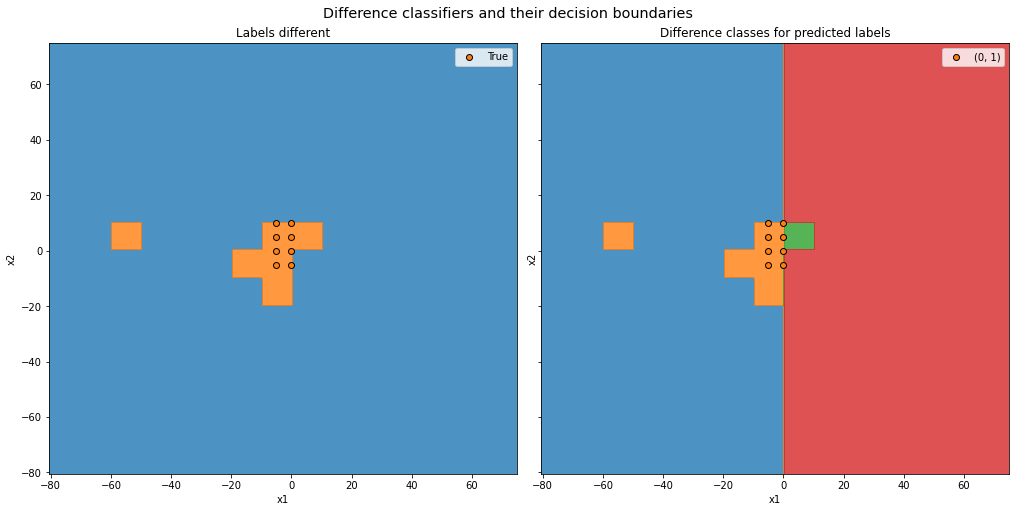

In [84]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

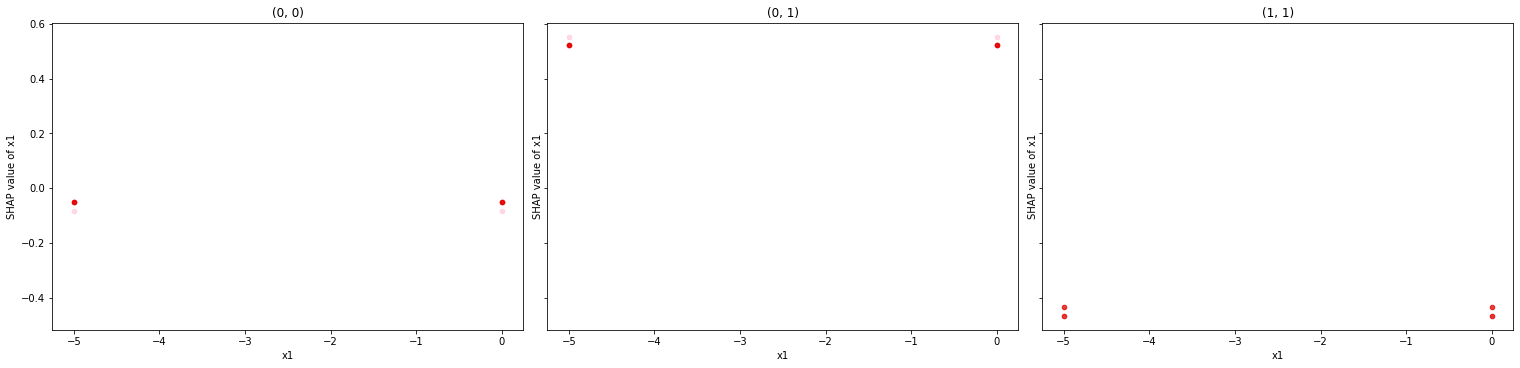

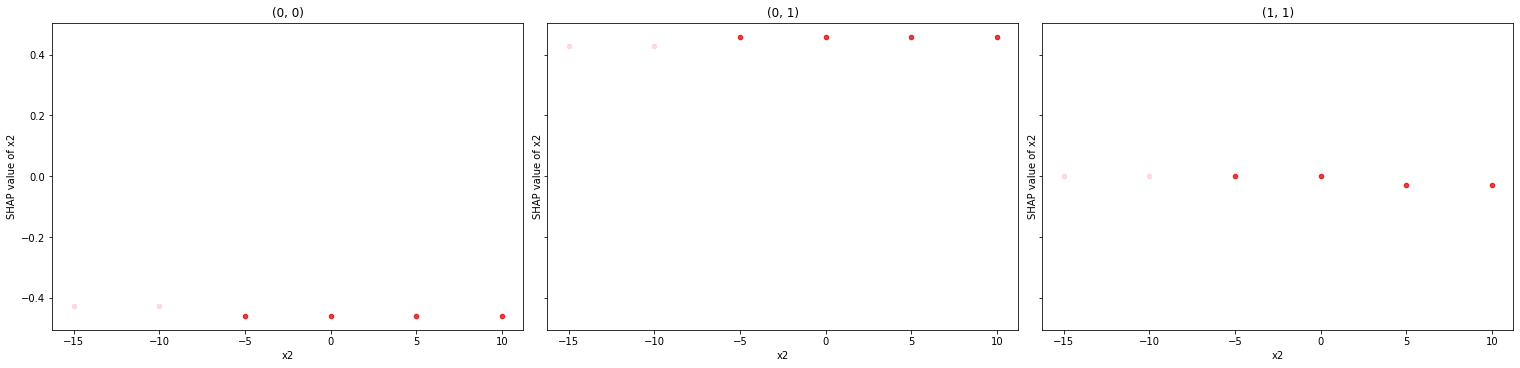

In [85]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [86]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,8.000000,8.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.672612,2.672612
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


In [87]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,8.000000,8.000000
mean,-2.500000,2.500000,2.500000
std,46.188022,5.976143,5.976143
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-1.250000,-1.250000
50%,-2.500000,2.500000,2.500000
75%,36.250000,6.250000,6.250000
max,75.000000,10.000000,10.000000


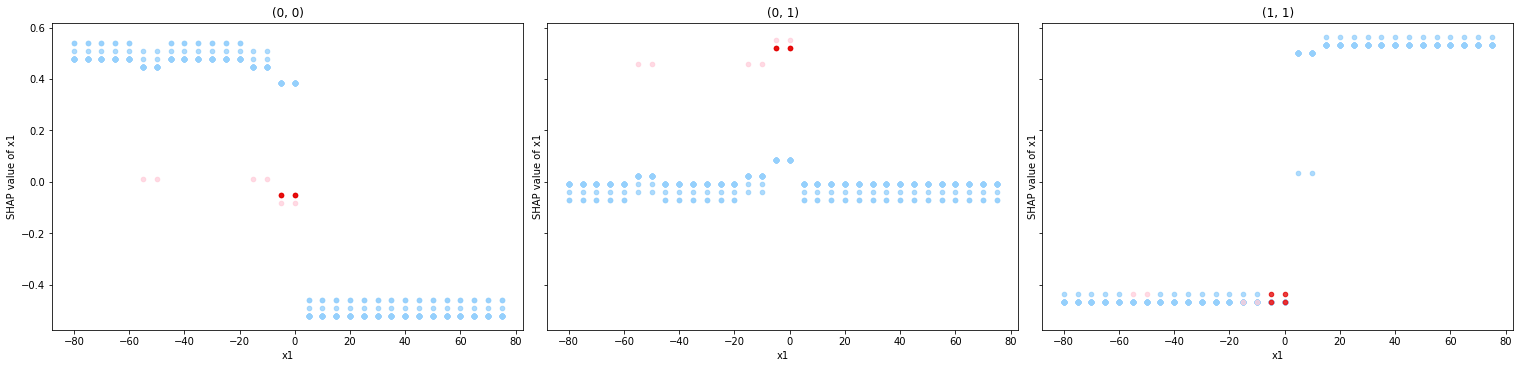

In [88]:
node.parent.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [89]:
node.test(x1=-20)

,before,after
"(0, 0)",NaN,8.0
"(0, 1)",8.0,NaN


In [90]:
node.test(x1=1)

,before,after
"(0, 1)",8.0,NaN
"(1, 0)",NaN,4.0
"(1, 1)",NaN,4.0


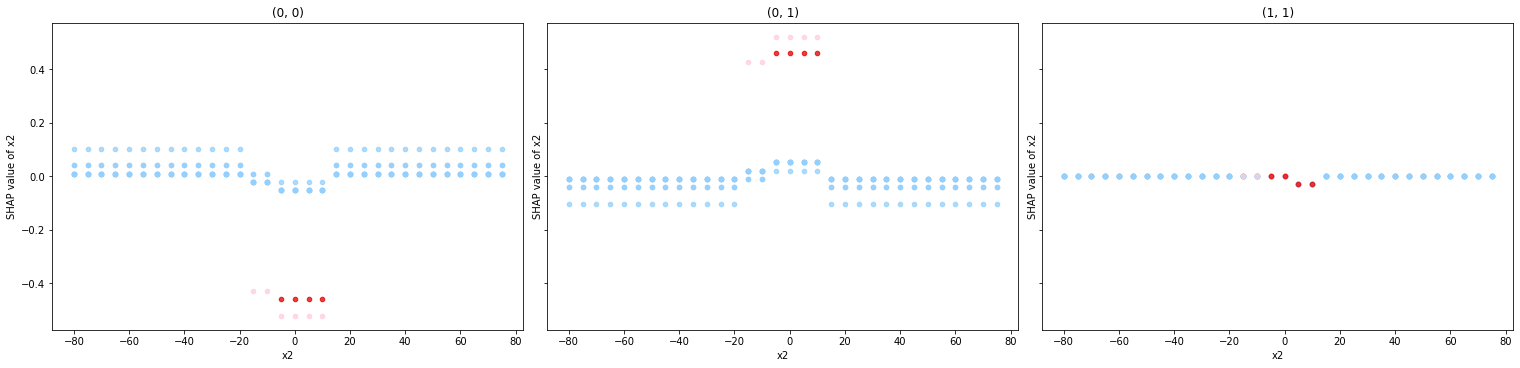

In [91]:
node.parent.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [92]:
node.test(x2=-20)

,before,after
"(0, 0)",NaN,8.0
"(0, 1)",8.0,NaN


In [93]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,8.0
"(0, 1)",8.0,NaN


### Node RLRRL

In [94]:
node = node.get_left()

RLRRL
(0, 1)    4
dtype: int64


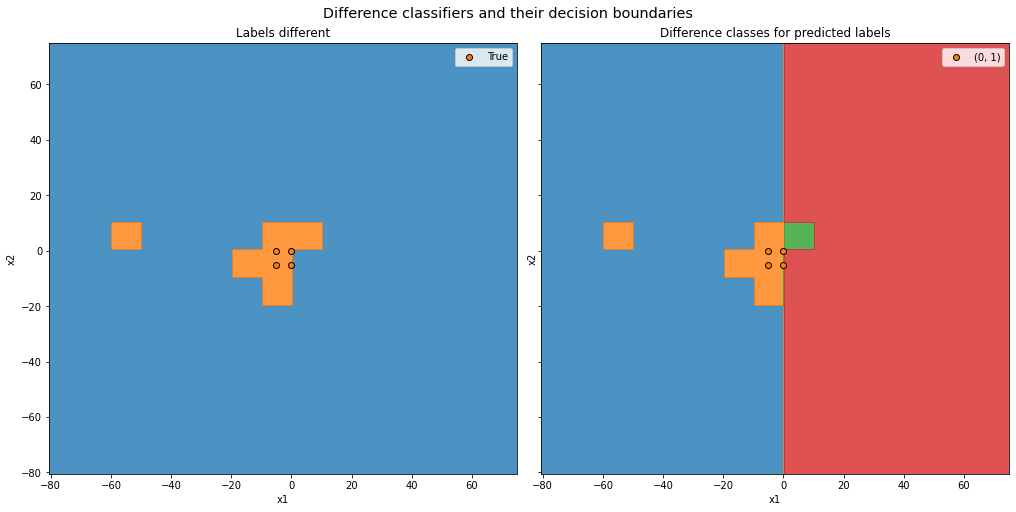

In [95]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

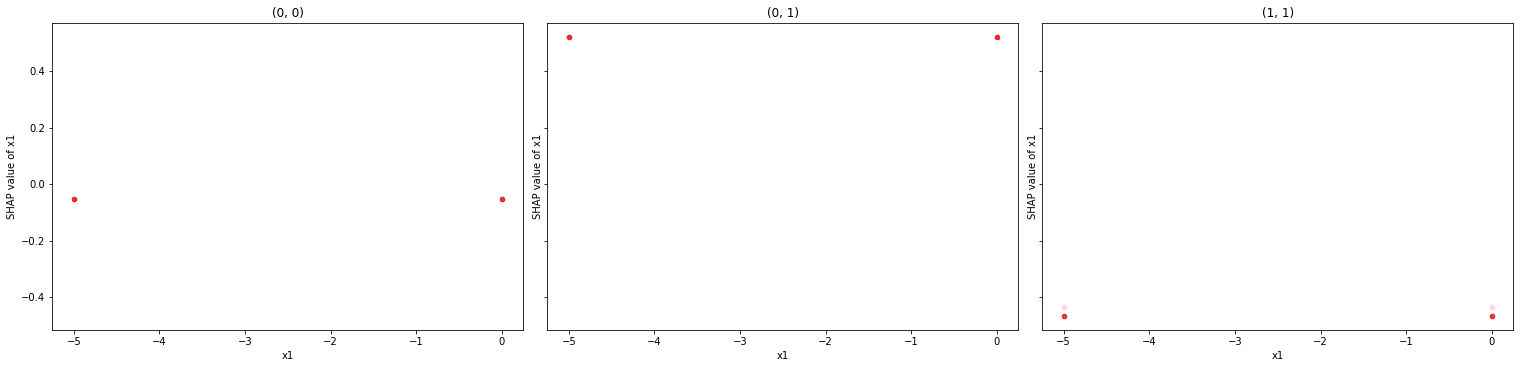

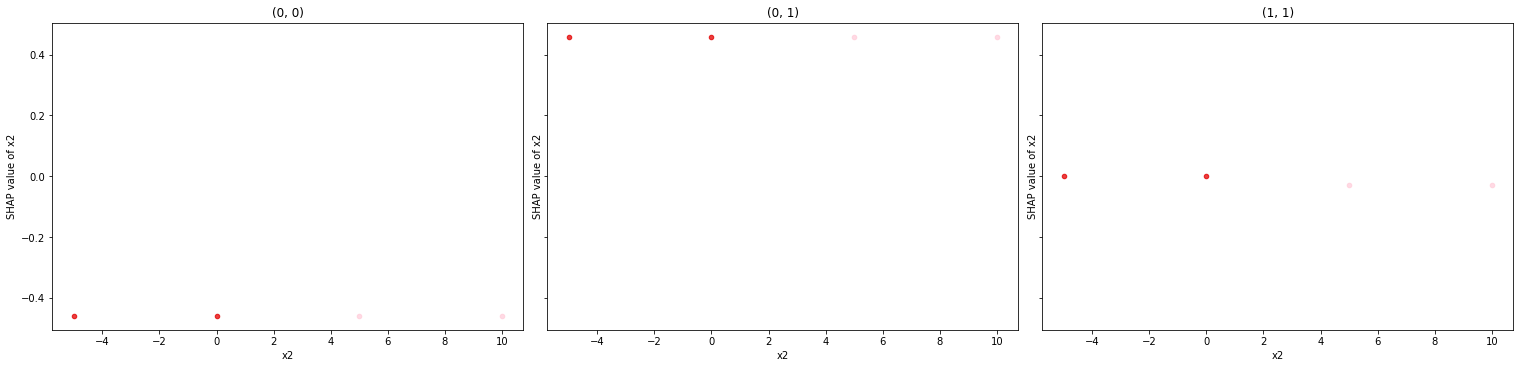

In [96]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [97]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


In [98]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


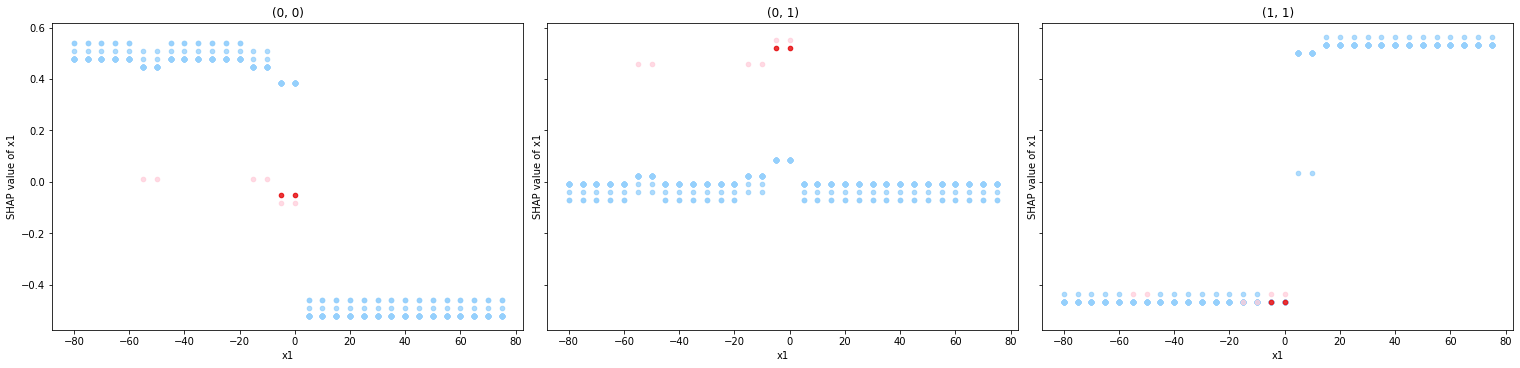

In [99]:
node.parent.parent.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [100]:
node.test(x1=-20)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [101]:
node.test(x1=1)

,before,after
"(0, 1)",4.0,NaN
"(1, 1)",NaN,4.0


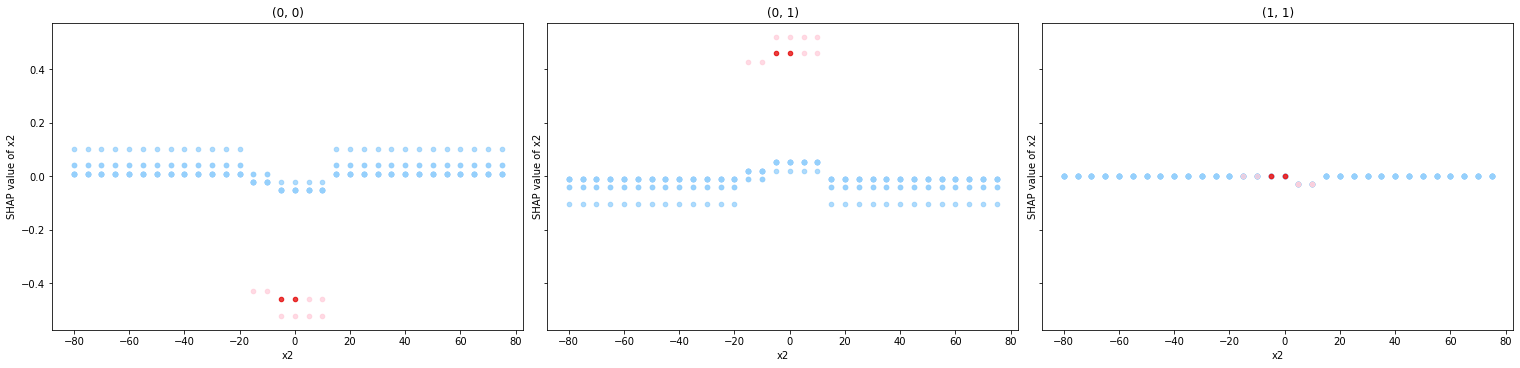

In [102]:
node.parent.parent.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [103]:
node.test(x2=-20)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [104]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


### Node RLRRR

In [105]:
node = node.parent.get_right()

RLRRR
(0, 1)    4
dtype: int64


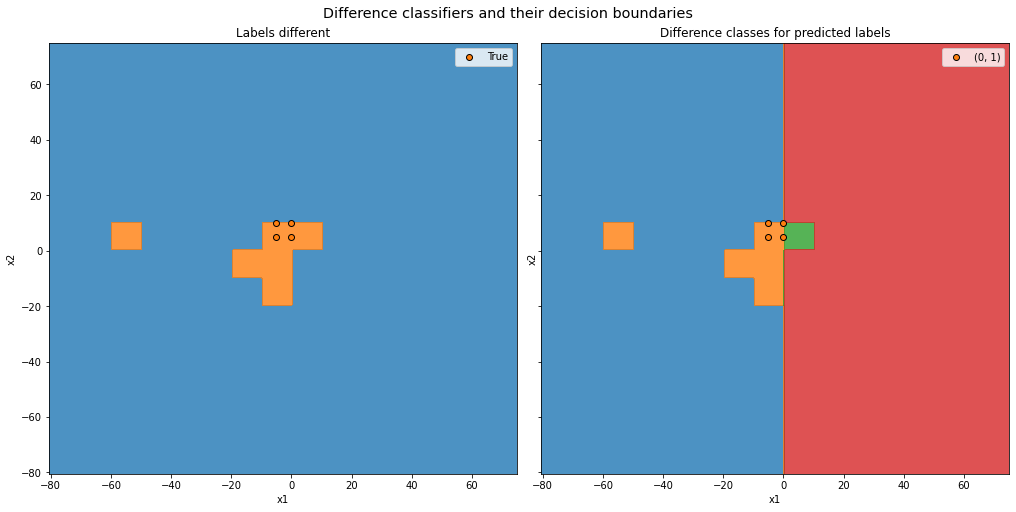

In [106]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

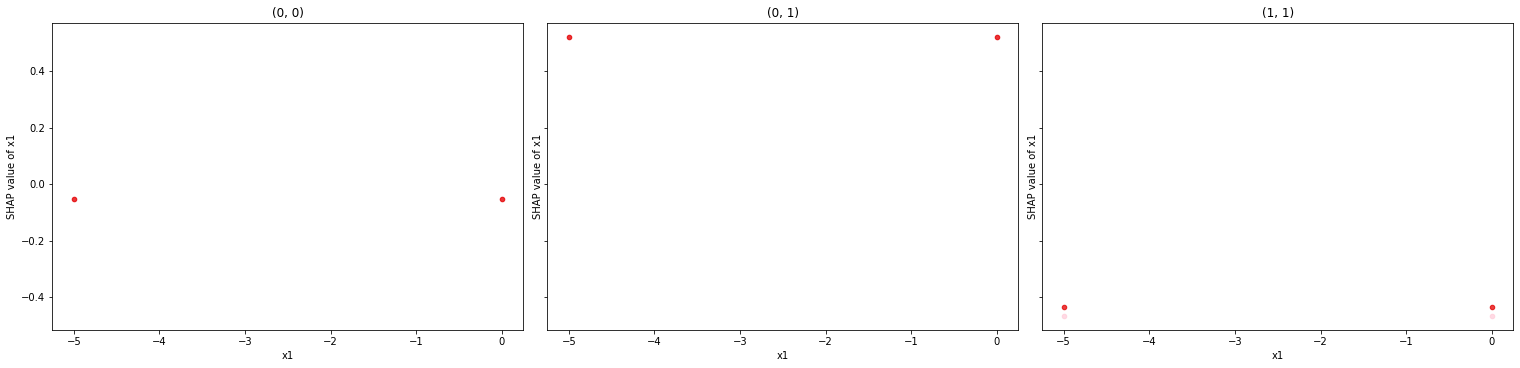

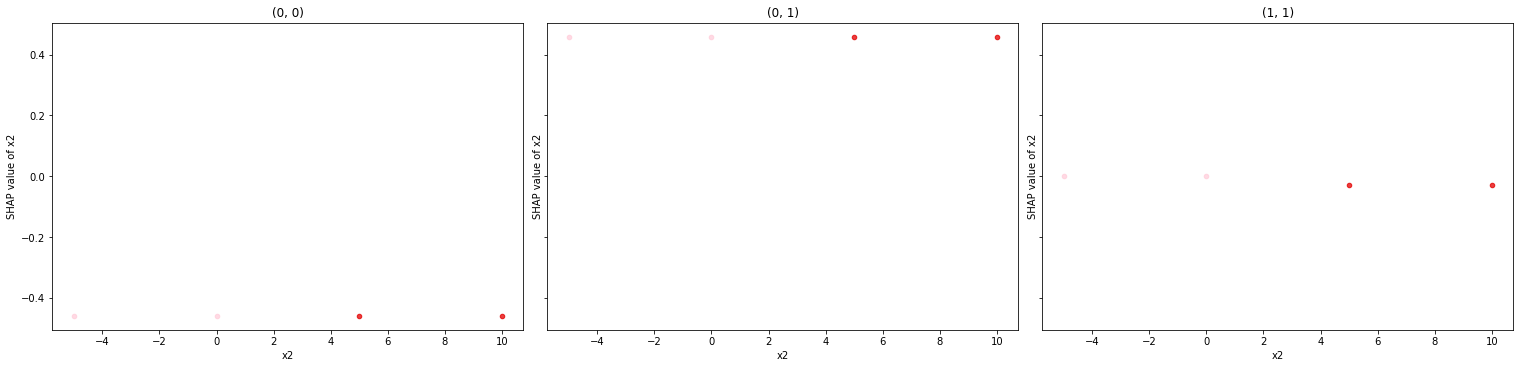

In [107]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [108]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,-2.500000,-2.500000
std,46.188022,2.886751,2.886751
min,-80.000000,-5.000000,-5.000000
25%,-41.250000,-5.000000,-5.000000
50%,-2.500000,-2.500000,-2.500000
75%,36.250000,0.000000,0.000000
max,75.000000,0.000000,0.000000


In [109]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,7.500000,7.500000
std,46.188022,2.886751,2.886751
min,-80.000000,5.000000,5.000000
25%,-41.250000,5.000000,5.000000
50%,-2.500000,7.500000,7.500000
75%,36.250000,10.000000,10.000000
max,75.000000,10.000000,10.000000


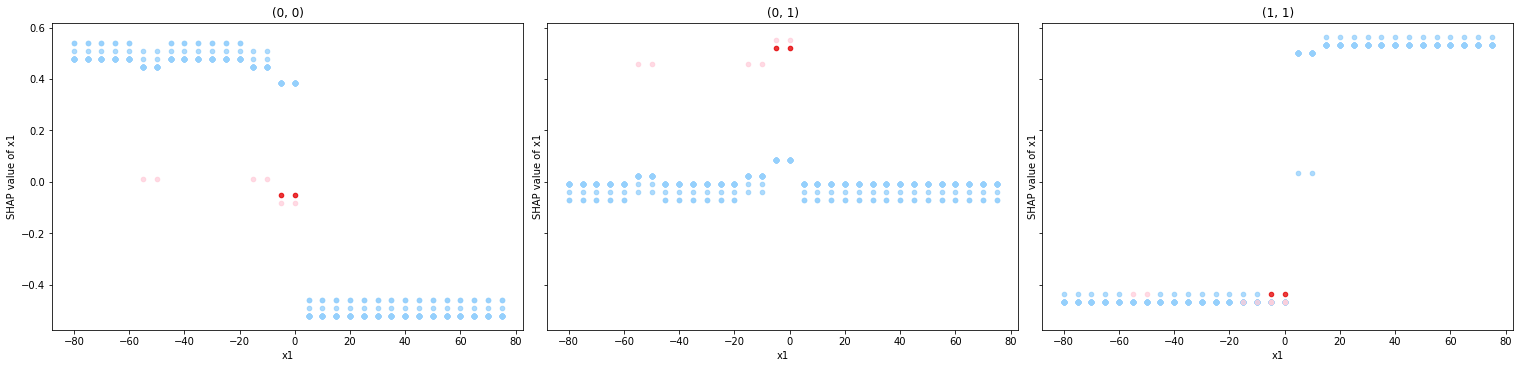

In [110]:
node.parent.parent.parent.parent.parent.plot_feature('x1', focus=node, alpha=0.5)

In [111]:
node.test(x1=-10)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [112]:
node.test(x1=1)

,before,after
"(0, 1)",4.0,NaN
"(1, 0)",NaN,4.0


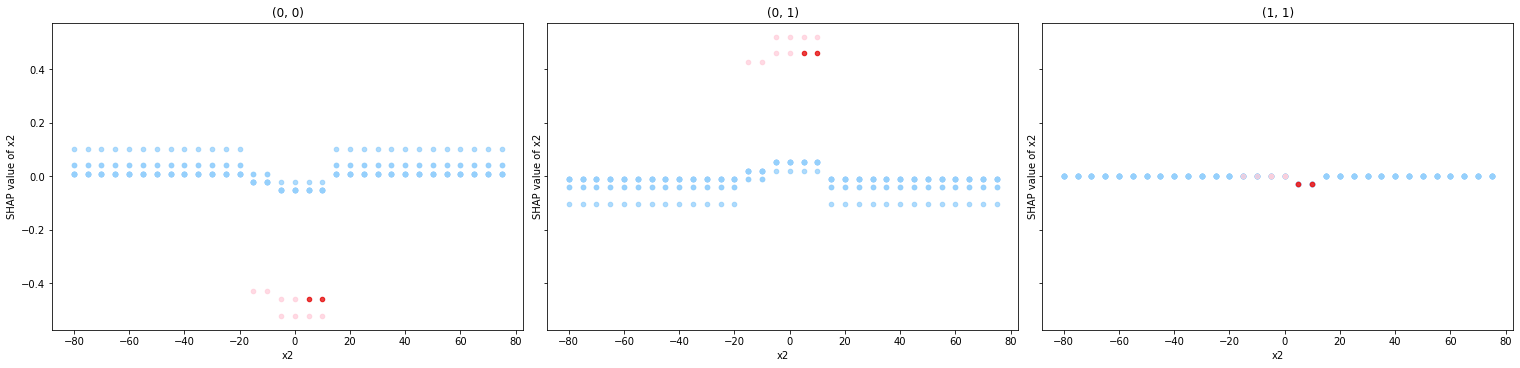

In [113]:
node.parent.parent.parent.parent.plot_feature('x2', focus=node, alpha=0.5)

In [114]:
node.test(x2=-20)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


In [115]:
node.test(x2=11)

,before,after
"(0, 0)",NaN,4.0
"(0, 1)",4.0,NaN


## Clustering of Class $(1,0)$ SHAP Values

In [116]:
node, Z = make_clustering(comparer, explanations.mclass_diff.labels, '(1, 0)', ['(0, 0)', '(1, 0)', '(1, 1)'])

root
(0, 0)    524
(1, 1)    476
(0, 1)     20
(1, 0)      4
dtype: int64


### Root Node

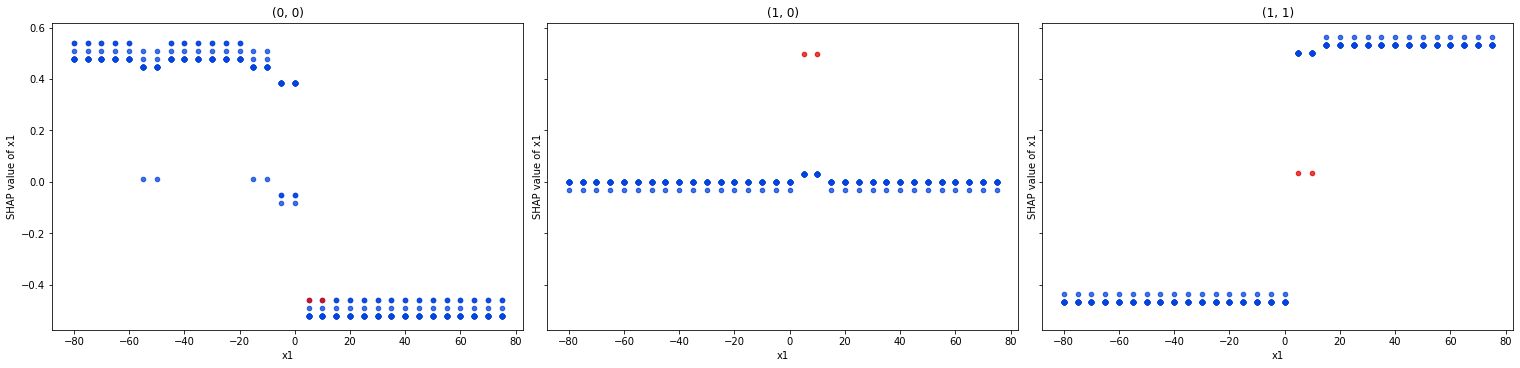

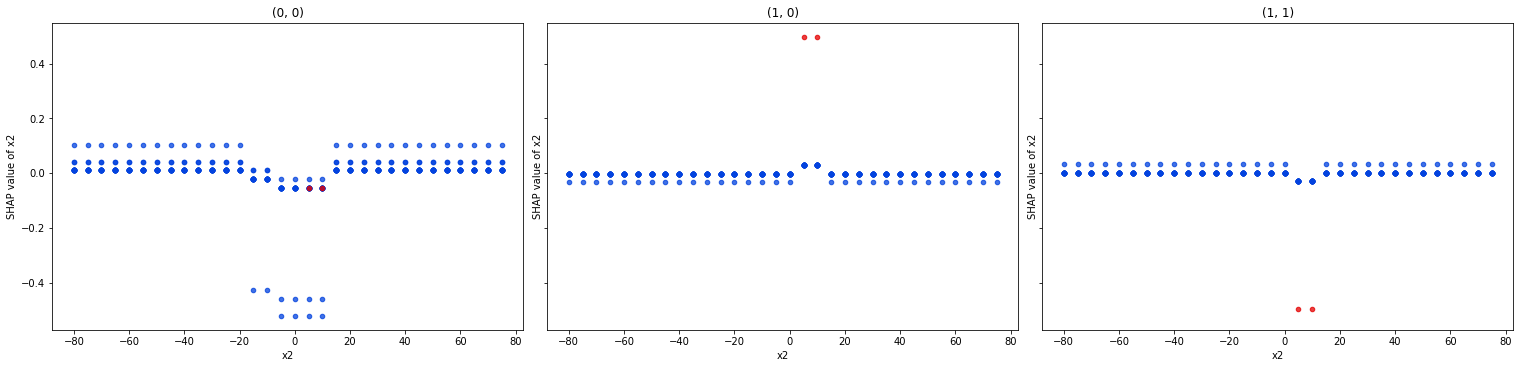

In [117]:
for feature in global_feature_order:
    node.plot_feature(feature, alpha=0.5)

In [118]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,1024.000000,4.000000
mean,-2.500000,-2.500000,7.500000
std,46.188022,46.188022,2.886751
min,-80.000000,-80.000000,5.000000
25%,-41.250000,-41.250000,5.000000
50%,-2.500000,-2.500000,7.500000
75%,36.250000,36.250000,10.000000
max,75.000000,75.000000,10.000000


In [119]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,1024.000000,4.000000
mean,-2.500000,-2.500000,7.500000
std,46.188022,46.188022,2.886751
min,-80.000000,-80.000000,5.000000
25%,-41.250000,-41.250000,5.000000
50%,-2.500000,-2.500000,7.500000
75%,36.250000,36.250000,10.000000
max,75.000000,75.000000,10.000000


### Node R

In [120]:
node = node.get_right()

R
(1, 1)    476
(1, 0)      4
dtype: int64


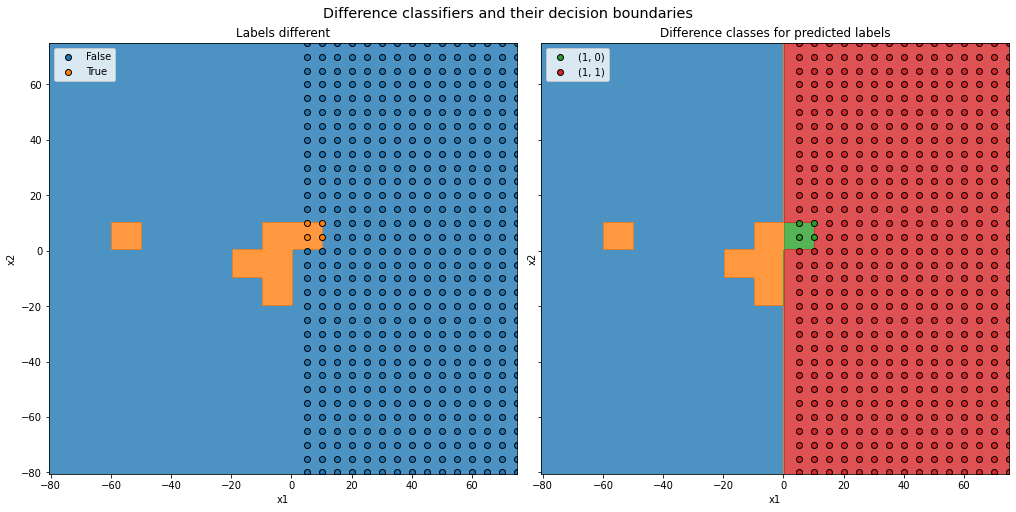

In [121]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

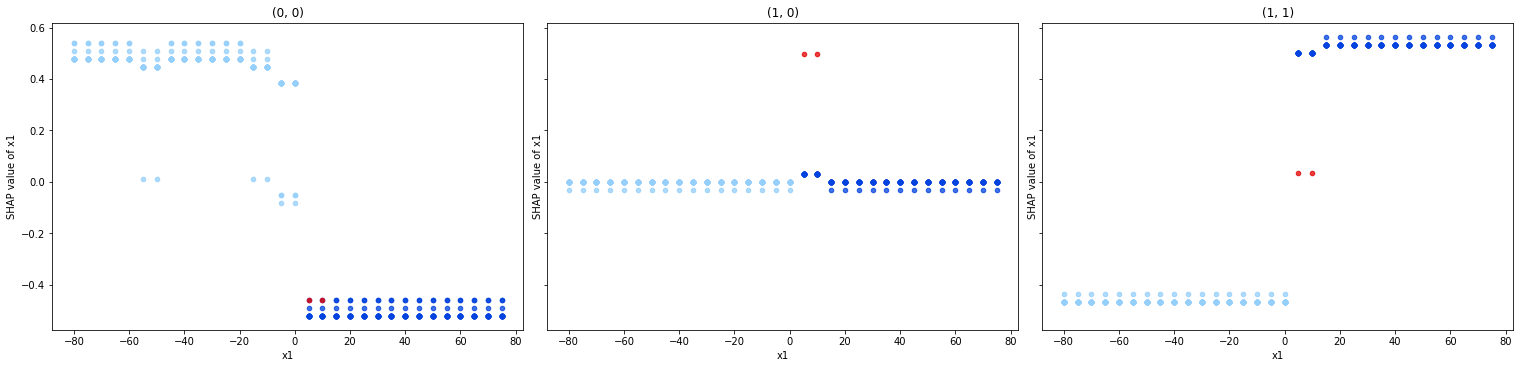

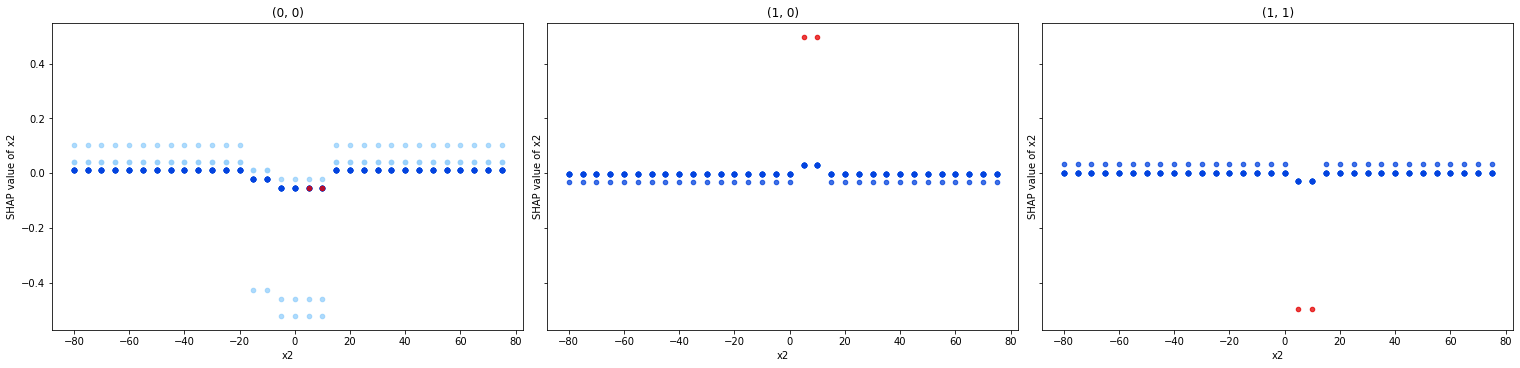

In [122]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [123]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,480.000000,4.000000
mean,-2.500000,40.000000,7.500000
std,46.188022,21.625007,2.886751
min,-80.000000,5.000000,5.000000
25%,-41.250000,20.000000,5.000000
50%,-2.500000,40.000000,7.500000
75%,36.250000,60.000000,10.000000
max,75.000000,75.000000,10.000000


In [127]:
node.test(x1=0)

,before,after
"(0, 1)",NaN,4.0
"(1, 0)",4.0,NaN


### Node RL

In [129]:
node = node.get_left()

RL
(1, 0)    4
dtype: int64


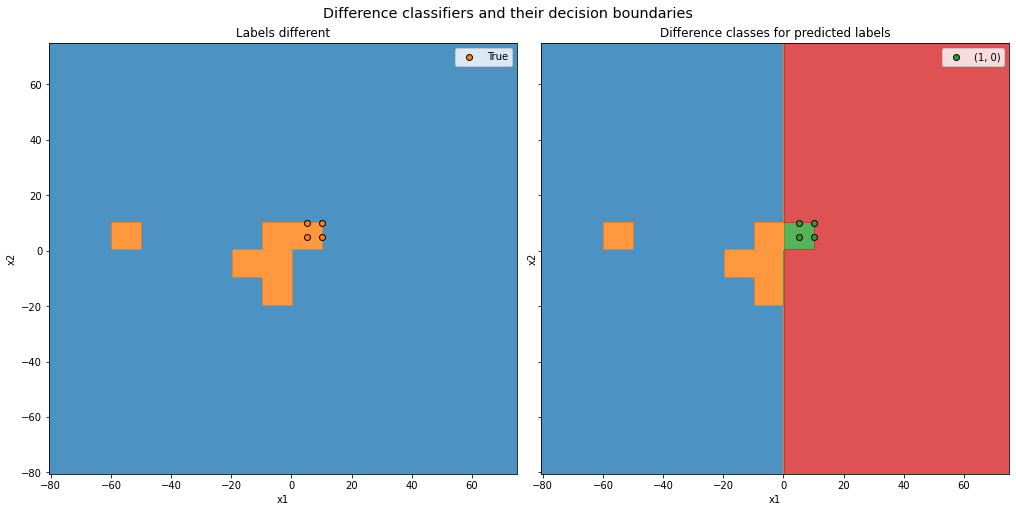

In [130]:
comparer.plot_decision_boundaries(node.shap_values.data, xlim=xlim, ylim=ylim)

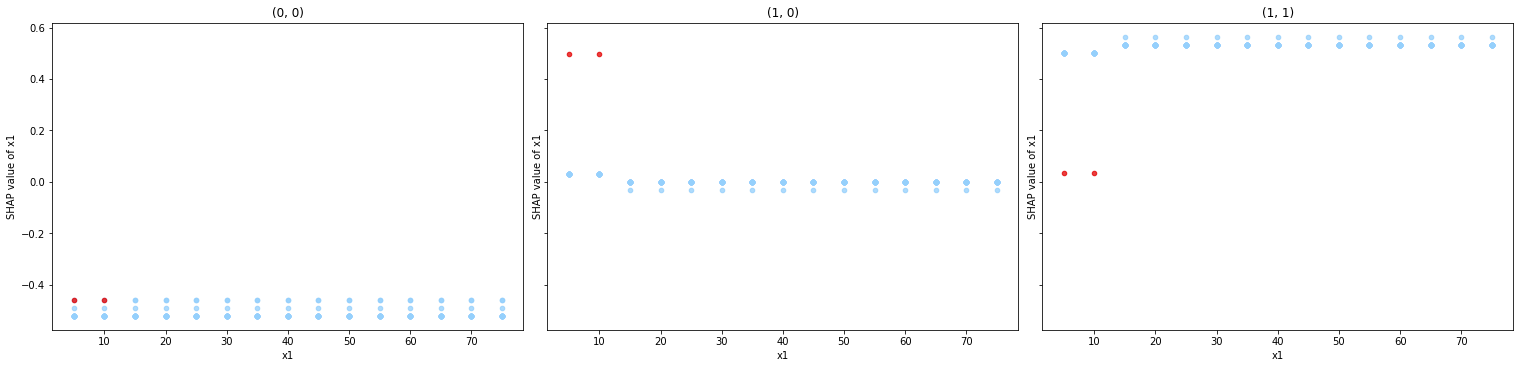

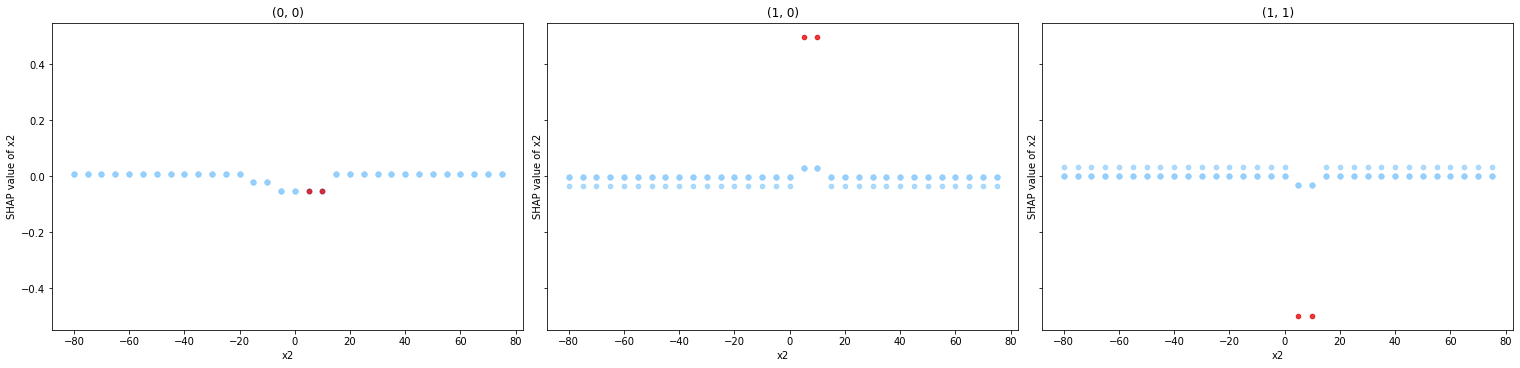

In [131]:
for feature in global_feature_order:
    node.parent.plot_feature(feature, focus=node, alpha=0.5)

In [132]:
node.describe_feature('x1')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,7.500000,7.500000
std,46.188022,2.886751,2.886751
min,-80.000000,5.000000,5.000000
25%,-41.250000,5.000000,5.000000
50%,-2.500000,7.500000,7.500000
75%,36.250000,10.000000,10.000000
max,75.000000,10.000000,10.000000


In [133]:
node.describe_feature('x2')

,global,local-all,local-diff
count,1024.000000,4.000000,4.000000
mean,-2.500000,7.500000,7.500000
std,46.188022,2.886751,2.886751
min,-80.000000,5.000000,5.000000
25%,-41.250000,5.000000,5.000000
50%,-2.500000,7.500000,7.500000
75%,36.250000,10.000000,10.000000
max,75.000000,10.000000,10.000000


In [134]:
node.test(x1=11)

,before,after
"(1, 0)",4.0,NaN
"(1, 1)",NaN,4.0


In [135]:
node.test(x1=0)

,before,after
"(0, 1)",NaN,4.0
"(1, 0)",4.0,NaN


In [137]:
node.test(x2=0)

,before,after
"(1, 0)",4.0,NaN
"(1, 1)",NaN,4.0


In [139]:
node.test(x2=11)

,before,after
"(1, 0)",4.0,NaN
"(1, 1)",NaN,4.0
